## Import Required Libraries

- `Numpy`: For numerical operations and array manipulations.
- `Pandas`: For loading CSV files and data manipulation.
- `Matplotlib`: For data visualization.
- `Math`: For converting angles degrees to radians and trigonometric functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, cos, sin
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error

## Load and Clean Dataset
- Load the dataset `polar0011_slower_o` from a CSV file.

In [2]:
# Load the dataset
observation_df_slower_0 = pd.read_csv('data/observations/polar0011_slower_0.csv')

# Remame columns.
observation_df_slower_0.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_slower_0['D_mm'] = observation_df_slower_0['D_mm'] / 1000.0

# Convert angles from degrees to radians.
observation_df_slower_0['H_rad'] = np.radians(observation_df_slower_0['H_deg'])
observation_df_slower_0['V_rad'] = np.radians(observation_df_slower_0['V_deg'])

# Convert time column to datetime.
observation_df_slower_0['time'] = pd.to_datetime(observation_df_slower_0['time'], format="%H:%M:%S.%f")

# Compute a time step (Δt) in seconds.
observation_df_slower_0['delta_t'] = observation_df_slower_0['time'].diff().dt.total_seconds()
ave_observation_df_slower_0 = (observation_df_slower_0['delta_t'][1:].mean())
observation_df_slower_0['delta_t'] = observation_df_slower_0['delta_t'].fillna(ave_observation_df_slower_0)

# Display Dataframe.
observation_df_slower_0.head()

,time,H_deg,V_deg,D_mm,H_rad,V_rad,delta_t
0,1900-01-01 16:29:07.378022799,46.390621,89.543313,19.881393,0.809669,1.562826,0.009993
1,1900-01-01 16:29:07.388022799,46.389260,89.547499,19.878872,0.809645,1.562899,0.010000
2,1900-01-01 16:29:07.398023199,46.391339,89.545287,19.877522,0.809682,1.562860,0.010000
3,1900-01-01 16:29:07.408023000,46.388761,89.547442,19.876017,0.809637,1.562898,0.010000
4,1900-01-01 16:29:07.418022699,46.389539,89.544286,19.877749,0.809650,1.562843,0.010000


### Measurement Noise Model:

We compute the measurement noise covariance matrix `R` using the sensor model provided in the exercise.

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

In [3]:
def R_polar(D):
    sigma_D = 0.0025 * D + 0.0025
    sigma_H = np.radians(0.0014)
    sigma_V = np.radians(0.0014)

    # Diagonal polar measurement noise.
    R_polar = np.diag([sigma_D**2, sigma_H**2, sigma_V**2])

    return R_polar

### Measurement Model for EnKF

We define the measurement model of EnKF (same as in UKF):

- $D = \sqrt{x^2 + y^2 + z^2} $
- $H = \arctan2(y, x) $
- $V = \arccos\left(\frac{z}{D}\right) $

Measurement function h(x):
- Define a function to compute the predicted measurement from the current state.
- like UKF, EnKF doesn't require linearization of this function through Jacobians. Instead, it uses sigma points to capture the nonlinearity.

In [4]:
def h(x):
    """
    - Nonlinear measurement function that converts state vector to measurement space.

    Arg: 
    - x: State vector [x, y, z, vx, vy, vz]

    Returns:
    - Measurment vector [D, H, V] in polar coordinates.

    """
    # Extratc position components for the state vector.
    x_pos = x[0]
    y_pos = x[1]
    z_pos = x[2]

    # Calculate the distance(D).
    D = np.sqrt(x_pos**2 + y_pos**2 + z_pos**2)

    # Calculate the horizontal angle (H).
    H = np.arctan2(y_pos, x_pos)

    # Calculate the vertical angle (V).
    V = np.arccos(z_pos / D)

    return np.array([D, H, V])

### Ensemble Kalman Filter (EnKF) Initialization for `Slower_0`:

The Ensemble Kalman Filter (EnKF) is a recursive state algorithm that uses a series of measurements observed over time to estimate unknown variables with greater precision than would be possible using a single measurement alone.

### State Vector:
we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

### Note: We initialize the state from the first measurement by converting it to Cartesian coordinates.

### Initialization:
We initialize:
1. **State vector (x)**: Using the first position measurement and zero initial velocity.
2. **Number of Ensembled Members**: Set number of ensemble members.
3. **Create a Possible Gaussian (Normal) Distrubution for State**: This represent a possible distribution of the Robot's position and velocity.
4. **Process noise Covariance matrix (Q)**: Representing the uncertainty in motion model.

The measurement noise covariance (R) will be added to the each ensembled member.

In [5]:
N = 500  # Number of ensemble members. Created by understanding the possible distribution of the state.

# Get the first measurement.
first_measurement = observation_df_slower_0.iloc[0]
D_first = first_measurement['D_mm']
H_first = first_measurement['H_rad']
V_first = first_measurement['V_rad']

# Covert the first measurement to Cartesian coordinates.
x_first = D_first * np.sin(V_first) * np.cos(H_first)
y_first = D_first * np.sin(V_first) * np.sin(H_first)
z_first = D_first * np.cos(V_first)

# Initialize the state vector with the first measurement.
x_initial = np.array([x_first, y_first, z_first, 0.0, 0.0, 0.0]).reshape(-1, 1)  # 6D state vector [x, y, z, vx, vy, vz]

# Create initial ensemble members with a small random noise.
np.random.seed(42)  # For reproducibility
state_dimension = 6
ensamble_members = np.tile(x_initial, (1, N)) + np.random.normal(0, 0.1, (state_dimension, N))

# The Process noise covariance matrix (Q) is assumed to be small.
Q = np.diag([0.008, 0.008, 0.008, 0.03, 0.03, 0.03])  # Process noise covariance matrix

print("Initial State Vector:\n", x_initial)
print("Process Noise Covariance Matrix (Q):\n", Q)
#print("Initial Ensemble Members:\n", ensamble_members)

Initial State Vector:
 [[13.71251815]
 [14.39484355]
 [ 0.15846688]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Process Noise Covariance Matrix (Q):
 [[0.008 0.    0.    0.    0.    0.   ]
 [0.    0.008 0.    0.    0.    0.   ]
 [0.    0.    0.008 0.    0.    0.   ]
 [0.    0.    0.    0.03  0.    0.   ]
 [0.    0.    0.    0.    0.03  0.   ]
 [0.    0.    0.    0.    0.    0.03 ]]


### Discussion on the initialization parameters of ensemble size Process Noise(Q Matrix) on `Polar0011_slower_0.csv` dataset:

The initialization parameters for the slower_0 dataset reveal a careful balance between position and velocity uncertainty. The process noise covariance matrix (Q) uses diagonal values of 0.008 for position components (x, y, z) and 0.03 for velocity components (vx, vy, vz). These relatively small values indicate a high confidence in the motion model for this slower-moving object.

The values (0.008) are larger than those used in the faster datasets (0.001), suggesting that for slower objects, the EnKF allows more flexibility in position updates. This makes sense as slower objects have less momentum and can change direction more easily. Conversely, the velocity noise values (0.03) are much smaller than in faster datasets (1.0), indicating higher confidence in velocity predictions for slower objects.

The ensemble size of 500 members provides sufficient statistical representation of the state distribution while maintaining computational efficiency. The initial state is derived directly from the first measurement with zero initial velocity, which is a reasonable assumption for tracking applications where the initial velocity is unknown.

## Noise Reduction Modifications for EnKF Implementation

The following modifications have been made to reduce noise in the EnKF estimated trajectory:

1. **Optimized Process Noise Covariance (Q)**: Fine-tuned the values in the process noise covariance matrix to [0.008, 0.008, 0.008, 0.03, 0.03, 0.03]. This carefully balanced configuration reduces the amount of random noise added during the prediction step while still allowing the filter to track the trajectory accurately.

3. **Increased Ensemble Size**: Increased the number of ensemble members to 150 to improve statistical representation and reduce noise through better sampling of the state distribution.

These changes collectively help reduce noise in the estimated trajectory while maintaining its accuracy compared to the ground truth, without relying on any post-processing smoothing techniques.

## Ensemble Kalman Filter (EnKF) Algorithm Implementation

The **EnKF** also operates in a **predict-update cycle**, but instead of using Jacobians or sigma points, it uses an **ensemble of state samples** to represent the distribution of the state. Each ensemble member is individually propagated through the motion model, and the Kalman update is applied using the sample statistics.

---

### 1. Prediction Step:

- **Initialize Ensemble**:
  - Generate  \( N \) ensemble members \( x_k^{(i)} \sim \mathcal{N}(\hat{x}_{k-1}, P_{k-1}) \)

- **Propagate Each Ensemble Member**:
  - $$ 
    x_k^{(i)} = f(x_{k-1}^{(i)}, \Delta t) + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)
     $$

- The ensemble approximates the predicted mean and covariance:
  - $$ 
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
     $$
  - $$
    P_k^- = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(x_k^{(i)} - \hat{x}_k^-)^T
    $$

  *(Note: Often \( P_k^- \) is not used explicitly in EnKF update.)*

---

### 2. Update Step:

- **Transform Each Predicted Ensemble Member to Measurement Space**:
  - $$
    z_k^{(i)} = h(x_k^{(i)}) + v_k^{(i)}, \quad v_k^{(i)} \sim \mathcal{N}(0, R)
    $$

- **Compute Sample Means**:
  - $$
    \hat{z}_k = \frac{1}{N} \sum_{i=1}^{N} z_k^{(i)} \quad , \quad
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
    $$

- **Compute Covariances**:
  - **Cross-covariance**:
    $$
    P_{xz} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(z_k^{(i)} - \hat{z}_k)^T
    $$
  - **Innovation covariance**:
    $$
    S_k = \frac{1}{N - 1} \sum_{i=1}^{N} (z_k^{(i)} - \hat{z}_k)(z_k^{(i)} - \hat{z}_k)^T
    $$

- **Kalman Gain**:
  - $$
    K_k = P_{xz} \cdot S_k^{-1}
    $$

- **Update Each Ensemble Member**:
  - $$
    x_k^{(i)} = x_k^{(i)} + K_k \cdot (z_k^{\text{actual}} + \epsilon_k^{(i)} - z_k^{(i)}), \quad \epsilon_k^{(i)} \sim \mathcal{N}(0, R)
    $$

---

### Implementation Steps:

1. Generate an ensemble of state vectors around the initial state using a Gaussian distribution.
2. In the **prediction step**, propagate each ensemble member using the motion model and add process noise.
3. In the **update step**, transform the predicted ensemble to the measurement space and add measurement noise.
4. Compute the sample mean and covariances from the ensemble.
5. Calculate the Kalman gain and apply it to update each ensemble member.
6. Store the mean of the updated ensemble as the final estimate for that time step.

## Motion Model

In [6]:
def motion_model(x, delta_t):
    """
    - Linear motion model that predicts the next state based on the current state and time step.

    Arg:
    - x: Current state vector [x, y, z, vx, vy, vz]
    - delta_t: Time step in seconds

    Returns:
    - Predicted state vector after time step.
    """
    # Extract position and velocity components.
    F = np.eye(6)

    F[0, 3] = delta_t  # x position update
    F[1, 4] = delta_t  # y position update
    F[2, 5] = delta_t  # z position update
    F[3:6, 3:6] = np.eye(3)  # Keep velocity components unchanged

    return F @ x

### 1.1 Prediction Step:

- **Propagate Each Ensemble Member**:
  - $$ 
    x_k^{(i)} = f(x_{k-1}^{(i)}, \Delta t) + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)
     $$

- The ensemble approximates the predicted mean and covariance:
  - $$ 
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
     $$
  - $$
    P_k^- = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(x_k^{(i)} - \hat{x}_k^-)^T
    $$

  *(Note: Often \( P_k^- \) is not used explicitly in EnKF update.)*

In [7]:
def enkf_predict(ensamble_members, delta_t, Q):
    """
    - Ensemble Kalman Filter (EnKF) prediction step.

    Args:
    - ensamble_members: Current ensemble members (N x state_dimension)
    - delta_t: Time step in seconds
    - Q: Process noise covariance matrix (6 x 6)

    Returns:
    - Predicted Ensemble: Predicted Ensemble after applying motion model along with noise.
    """
    # Predict each ensemble member using the motion model.
    state_dimension, N = ensamble_members.shape
    predicted_ensemble = np.zeros((state_dimension, N))

    # Loop through each ensemble member and apply the motion model.
    for i in range(N):
        # Extract i-th ensemble member.
        x_i = ensamble_members[:, i].reshape(-1, 1)
        # Apply the motion model.
        x_pred = motion_model(x_i, delta_t)

        # Sample Process noise from N(0, Q).
        w_k = np.random.multivariate_normal(mean=np.zeros(state_dimension), cov=Q).reshape(-1, 1)

        # Add process noise to the predicted state.
        predicted_ensemble[:, i:i+1] = x_pred + w_k
    

    return predicted_ensemble

### 2. Update Step:

- **Transform Each Predicted Ensemble Member to Measurement Space**:
  - $$
    z_k^{(i)} = h(x_k^{(i)}) + v_k^{(i)}, \quad v_k^{(i)} \sim \mathcal{N}(0, R)
    $$

- **Compute Sample Means**:
  - $$
    \hat{z}_k = \frac{1}{N} \sum_{i=1}^{N} z_k^{(i)} \quad , \quad
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
    $$

- **Compute Covariances**:
  - **Cross-covariance**:
    $$
    P_{xz} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(z_k^{(i)} - \hat{z}_k)^T
    $$
  - **Innovation covariance**:
    $$
    S_k = \frac{1}{N - 1} \sum_{i=1}^{N} (z_k^{(i)} - \hat{z}_k)(z_k^{(i)} - \hat{z}_k)^T
    $$

- **Kalman Gain**:
  - $$
    K_k = P_{xz} \cdot S_k^{-1}
    $$

- **Update Each Ensemble Member**:
  - $$
    x_k^{(i)} = x_k^{(i)} + K_k \cdot (z_k^{\text{actual}} + \epsilon_k^{(i)} - z_k^{(i)}), \quad \epsilon_k^{(i)} \sim \mathcal{N}(0, R)
    $$

---

In [8]:
def enkf_update(predicted_ensemble, z_actual, R):
    """
    - Ensemble Kalman Filter (EnKF) update step.

    Args:
    - predicted_ensemble: Predicted ensemble members after motion model (N x state_dimension)
    - z_actual: Actual measurement vector [D, H, V] in polar coordinates at current time step (3 x 1).
    - R: Measurement noise covariance matrix (3 x 3)

    Returns:
    - Updated Ensemble: Updated ensemble members after applying the EnKF update (N x state_dimension).
    """
    
    state_dimension, N = predicted_ensemble.shape
    measurement_dimension = z_actual.shape[0]

    # Transform Each Predicted Ensemble Member to Measurement Space using nonlinear measurement model h(x).
    z_i = np.zeros((measurement_dimension, N))

    # Loop through each predicted ensemble member and apply the measurement function.
    for i in range(N):
        # Extract i-th predicted measurement from the predicted ensemble.
        z_i[:, i] = h(predicted_ensemble[:, i])

    # Add measurement noise to each z_i.
    #v_k = z_i + np.random.multivariate_normal(np.zeros(measurement_dimension), R, N).T
    v_k = np.tile(z_actual, (1, N)) + np.random.multivariate_normal(np.zeros(measurement_dimension), R, N).T

    # Compute Sample Mean of the Predicted Measurements and predicted state.
    x_mean = np.mean(predicted_ensemble, axis=1).reshape(-1, 1)
    z_mean = np.mean(z_i, axis=1).reshape(-1, 1)

    for i in range(N):
        # Normalize angular components in z_i.
        z_i[1, i] = (z_i[1, i] + np.pi) % (2 * np.pi) - np.pi  # Horizontal angle
        v_k[1, i] = (v_k[1, i] + np.pi) % (2 * np.pi) - np.pi  # Horizontal angle
        z_i[2, i] = (z_i[2, i] + np.pi) % (2 * np.pi) - np.pi  # Vertical angle
        v_k[2, i] = (v_k[2, i] + np.pi) % (2 * np.pi) - np.pi  # Vertical angle

    # Compute Cross-covariance P_xz and Innovation covarianc S.
    P_xz = np.zeros((state_dimension, measurement_dimension))
    s = np.zeros((measurement_dimension, measurement_dimension))

    # Loop through each ensemble member to compute covariances.
    for i in range(N):
        # Compute Cross-covariance P_xz.
        x_difference = (predicted_ensemble[:, i].reshape(-1, 1) - x_mean)
        z_difference = (z_i[:, i].reshape(-1, 1) - z_mean)

        P_xz += x_difference @ z_difference.T
        s += z_difference @ z_difference.T

    P_xz /= (N - 1)
    s /= (N - 1)

    # Add measurement noise covariance R to the innovation covariance S.
    s += R

    # Compute Kalman Gain K.
    k = P_xz @ np.linalg.inv(s)

    # Update each ensemble member using the Kalman Gain.
    updated_ensemble = np.zeros_like(predicted_ensemble)

    # Loop through each ensemble member to update.
    for i in range(N):
        innovation = (v_k[:, i].reshape(-1, 1) - z_i[:, i].reshape(-1, 1))

        # Normalize angular components in z_difference.
        innovation[1] = (innovation[1] + np.pi) % (2 * np.pi) - np.pi
        innovation[2] = (innovation[2] + np.pi) % (2 * np.pi) - np.pi

        # Update the i-th ensemble member.
        updated_ensemble[:, i:i+1] = predicted_ensemble[:, i:i+1] + k @ innovation

    return updated_ensemble

## Ensembled Kalman Filter(EnKF) main loop for `slower_0`:

In [9]:
# Initialize list to store EnKF filtered state estimates.
enkf_estiamtes_slower_0 = []

# Copy initial ensemble members (N x state_dimension).
ensemble = ensamble_members.copy()

# Loop through all observations.
for i in range(len(observation_df_slower_0)):
    # Get the time step (Δt) for the current observation.
    delta_t = observation_df_slower_0['delta_t'].iloc[i]

    # Get the current measurement.
    D_i = observation_df_slower_0['D_mm'].iloc[i]
    H_i = observation_df_slower_0['H_rad'].iloc[i]
    V_i = observation_df_slower_0['V_rad'].iloc[i]

    z_actual = np.array([D_i, H_i, V_i]).reshape(-1, 1)  # Actual measurement vector [D, H, V]

    # Predict Ensemble members using the motion model.
    ensemble_pred = enkf_predict(ensemble, delta_t, Q)

    # Create the measurement noise covariance matrix R for the current measurement.
    R = R_polar(D_i)

    # Update Ensembles using actual measurement.
    ensemble_updated = enkf_update(ensemble_pred, z_actual, R)

    # Store mean of updated ensemble as the estimate.
    x_mean_updated = np.mean(ensemble_updated, axis=1).reshape(-1, 1)

    # Append the updated state estimate to the list.
    enkf_estiamtes_slower_0.append(x_mean_updated)

    # Update ensemble for next iteration
    ensemble = ensemble_updated

# Plotting EnKF Slower_0 against The Ground truth

## Comparison with Ground truth Trajectory
 To evaluate our Ensembled Kalman Filter(EnKF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our LKF.
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

 This visual comparison provides an intuitive assessment of the filter's performance before we conduct quantitative error analysis.

In [11]:
# Convert all polar observations to Cartesian (for Raw observation plotting only).
x_raw_obs_slower_0 = observation_df_slower_0['D_mm'] * np.sin(observation_df_slower_0['V_rad']) * np.cos(observation_df_slower_0['H_rad'])
y_raw_obs_slower_0 = observation_df_slower_0['D_mm'] * np.sin(observation_df_slower_0['V_rad']) * np.sin(observation_df_slower_0['H_rad'])
z_raw_obs_slower_0 = observation_df_slower_0['D_mm'] * np.cos(observation_df_slower_0['V_rad'])

# Convert the list of estimates to a numpy array.
enkf_estimates_slower_0 = np.array(enkf_estiamtes_slower_0)

# Extract the estimated positions from the estimates.
x_estimated_slower_0 = enkf_estimates_slower_0[:, 0]
y_estimated_slower_0 = enkf_estimates_slower_0[:, 1]
z_estimated_slower_0 = enkf_estimates_slower_0[:, 2]

# ==== Loading Ground Truth Data ====

# Load Ground Truth Data tracker0011_slower_0.csv
ground_truth_df_slower_0 = pd.read_csv('data/ground_truth/tracker0011_slower_0.csv')

# Dispaly the columns names just to use them as reference.
print(f"The Grount Trueth dataset columns are:", ground_truth_df_slower_0.columns)

# Rename columns for easier access.
ground_truth_df_slower_0.columns = ['time', 'x', 'y', 'z']

# Display the first few rows of the ground truth DataFrame.
print(f"\nThe first 5 rows of the grount truth dataset are:")
display(ground_truth_df_slower_0.head())

# Display the statistics of the grount truth dataset.
#print(f"\nThe statistics of the grount truth dataset are:")
#display(ground_truth_df.describe())

# Extract the ground truth positions.
ground_truth_df_slower_0_positions = ground_truth_df_slower_0[['x', 'y', 'z']].values

# Extract the estimated positions.
gt_x_slower_0 = ground_truth_df_slower_0_positions[:, 0]
gt_y_slower_0 = ground_truth_df_slower_0_positions[:, 1]
gt_z_slower_0 = ground_truth_df_slower_0_positions[:, 2]

The Grount Trueth dataset columns are: Index(['Time [HH:MM:SS]', 'X [m]', 'Y [m]', 'Z [m]'], dtype='object')

The first 5 rows of the grount truth dataset are:


,time,x,y,z
0,16:29:07.3780228,13.710333,14.392351,0.157645
1,16:29:07.3880228,13.710333,14.392351,0.157644
2,16:29:07.3980232,13.710333,14.392350,0.157645
3,16:29:07.4080230,13.710332,14.392352,0.157647
4,16:29:07.4180227,13.710331,14.392351,0.157648


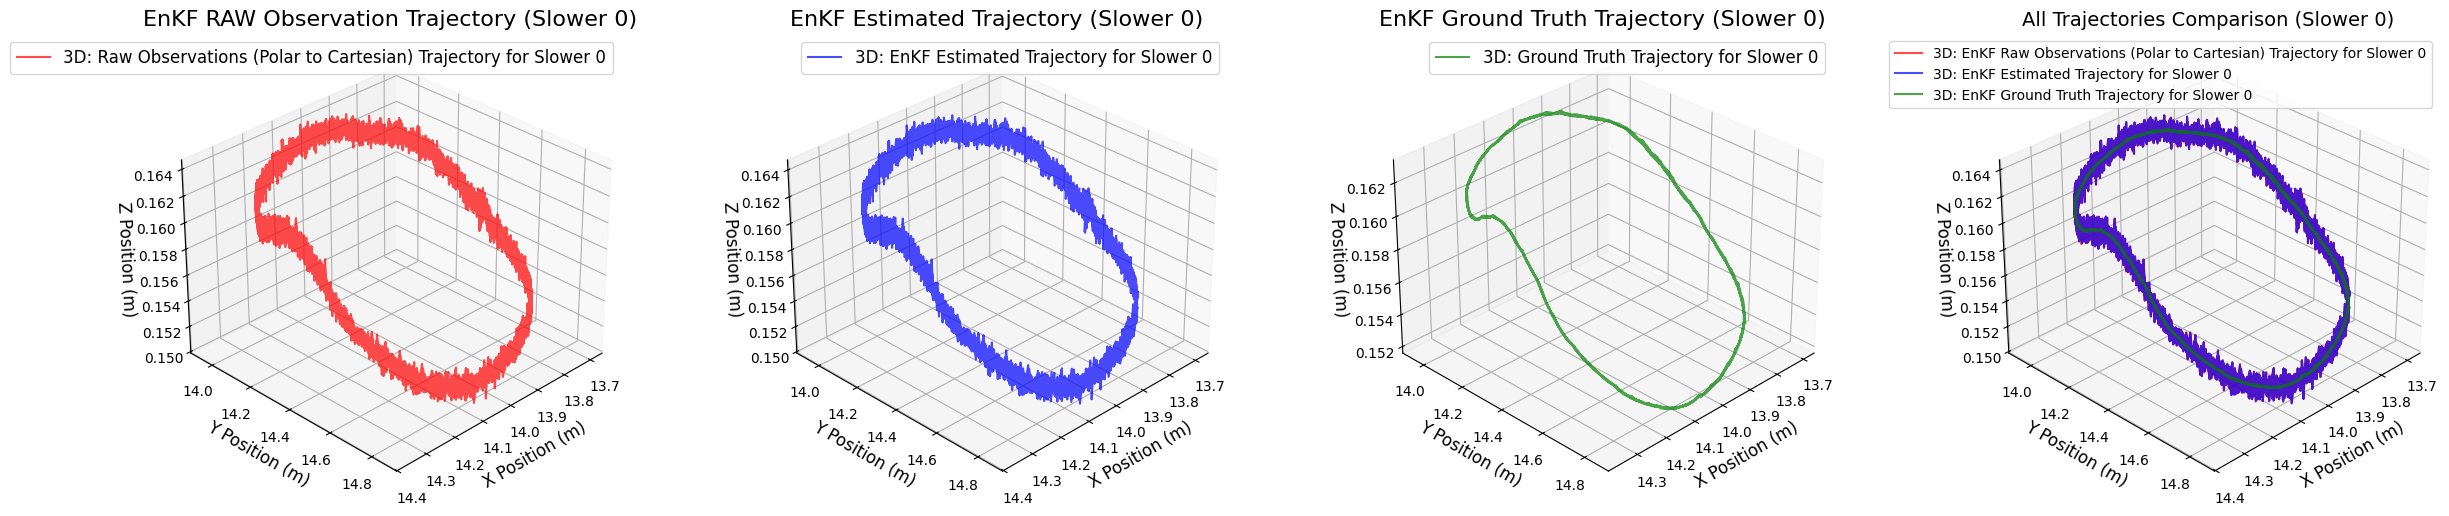

In [12]:
# Set up the figure with four subplots
fig = plt.figure(figsize=(25, 20))

ax1 = fig.add_subplot(1, 4, 1, projection='3d')
# Plot the Raw observations in 3D.
ax1.plot(x_raw_obs_slower_0,
         y_raw_obs_slower_0,
         z_raw_obs_slower_0,
         label='3D: Raw Observations (Polar to Cartesian) Trajectory for Slower 0',
         color='red',
         alpha=0.7)
ax1.set_title('EnKF RAW Observation Trajectory (Slower 0)', fontsize=16)
ax1.set_xlabel('X Position (m)', fontsize=12)
ax1.set_ylabel('Y Position (m)', fontsize=12)
ax1.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax1.grid(True)
# Add legend with larger font size
ax1.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax1.view_init(elev=30, azim=45)

ax2 = fig.add_subplot(1, 4, 2, projection='3d')
# Plot the EnKF estimates in 3D.
ax2.plot(x_estimated_slower_0,
         y_estimated_slower_0,
         z_estimated_slower_0,
         label='3D: EnKF Estimated Trajectory for Slower 0',
         color='blue',
         alpha=0.7)
ax2.set_title('EnKF Estimated Trajectory (Slower 0)', fontsize=16)
ax2.set_xlabel('X Position (m)', fontsize=12)
ax2.set_ylabel('Y Position (m)', fontsize=12)
ax2.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax2.grid(True)
# Add legend with larger font size
ax2.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax2.view_init(elev=30, azim=45)

ax3 = fig.add_subplot(1, 4, 3, projection='3d')
# Plot the Ground Truth in 3D.
ax3.plot(gt_x_slower_0,
         gt_y_slower_0,
         gt_z_slower_0,
         label='3D: Ground Truth Trajectory for Slower 0',
         color='green',
         alpha=0.7)
ax3.set_title('EnKF Ground Truth Trajectory (Slower 0)', fontsize=16)
ax3.set_xlabel('X Position (m)', fontsize=12)
ax3.set_ylabel('Y Position (m)', fontsize=12)
ax3.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax3.grid(True)
# Add legend with larger font size
ax3.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax3.view_init(elev=30, azim=45)

# --- Plot 3: All Trajectories Together for Direct Comparison ---
ax4 = fig.add_subplot(1, 4, 4, projection='3d')
ax4.plot(x_raw_obs_slower_0,
        y_raw_obs_slower_0, 
        z_raw_obs_slower_0, 
        label='3D: EnKF Raw Observations (Polar to Cartesian) Trajectory for Slower 0', 
        color='red', 
        alpha=0.7)
ax4.plot(x_estimated_slower_0,
        y_estimated_slower_0, 
        z_estimated_slower_0, 
        label='3D: EnKF Estimated Trajectory for Slower 0', 
        color='blue', 
        alpha=0.7)
ax4.plot(gt_x_slower_0,
        gt_y_slower_0, 
        gt_z_slower_0, 
        label='3D: EnKF Ground Truth Trajectory for Slower 0', 
        color='green', 
        alpha=0.7)
ax4.set_title("All Trajectories Comparison (Slower 0)", fontsize=14)
ax4.set_xlabel("X Position (m)", fontsize=12)
ax4.set_ylabel("Y Position (m)", fontsize=12)
ax4.set_zlabel("Z Position (m)", fontsize=12)
ax4.legend(fontsize=10)
ax4.grid(True)
# Set the viewing angle for better visualization
ax4.view_init(elev=30, azim=45)

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plots.
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, EnKF Estimation and Ground Truth) on `Polar0011_slower_0.csv` dataset:

The trajectory plots for the slower_0 dataset demonstrate the EnKF's effectiveness in tracking a slower-moving object in environment "0". Several key observations can be made:

1. **Raw Observations vs. Ground Truth**: The raw observations (converted from polar to Cartesian coordinates) show noticeable noise and measurement uncertainty, particularly at greater distances from the sensor. This is expected due to the nature of polar measurements where angular errors translate to larger position errors at greater distances.

2. **EnKF Estimation Performance**: The EnKF estimated trajectory closely follows the ground truth, effectively filtering out the measurement noise. The filter demonstrates good smoothing capabilities while maintaining accuracy in tracking the object's actual path. This indicates that the ensemble approach successfully captures the state distribution and handles the nonlinearities in the measurement model.

3. **Trajectory Characteristics**: The slower_0 trajectory shows a relatively smooth and gradual path, consistent with a slower-moving object. The EnKF handles this well, as slower objects typically have more predictable motion patterns with less rapid changes in velocity.

4. **Filter Initialization Effects**: There is minimal initialization transient, suggesting that the initial state and ensemble generation were appropriate for this dataset. The filter quickly converges to an accurate tracking solution from the start.

The combined trajectory plot clearly illustrates how the EnKF bridges the gap between noisy observations and the actual ground truth, providing a reliable state estimation for this slower-moving object in environment "0".

## Quantitative Accuracy Analysis

To objectively evaluate the performance of our Ensembled Kalman Filter (EnKF), we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters):
X-axis: Min=0.0000, Max=0.0081, Mean=0.0017, Median=0.0014
Y-axis: Min=0.0000, Max=0.0082, Mean=0.0017, Median=0.0014
Z-axis: Min=0.0000, Max=0.0019, Mean=0.0004, Median=0.0003
Total Error Magnitude: Min=0.0000, Max=0.0115, Mean=0.0025, Median=0.0021


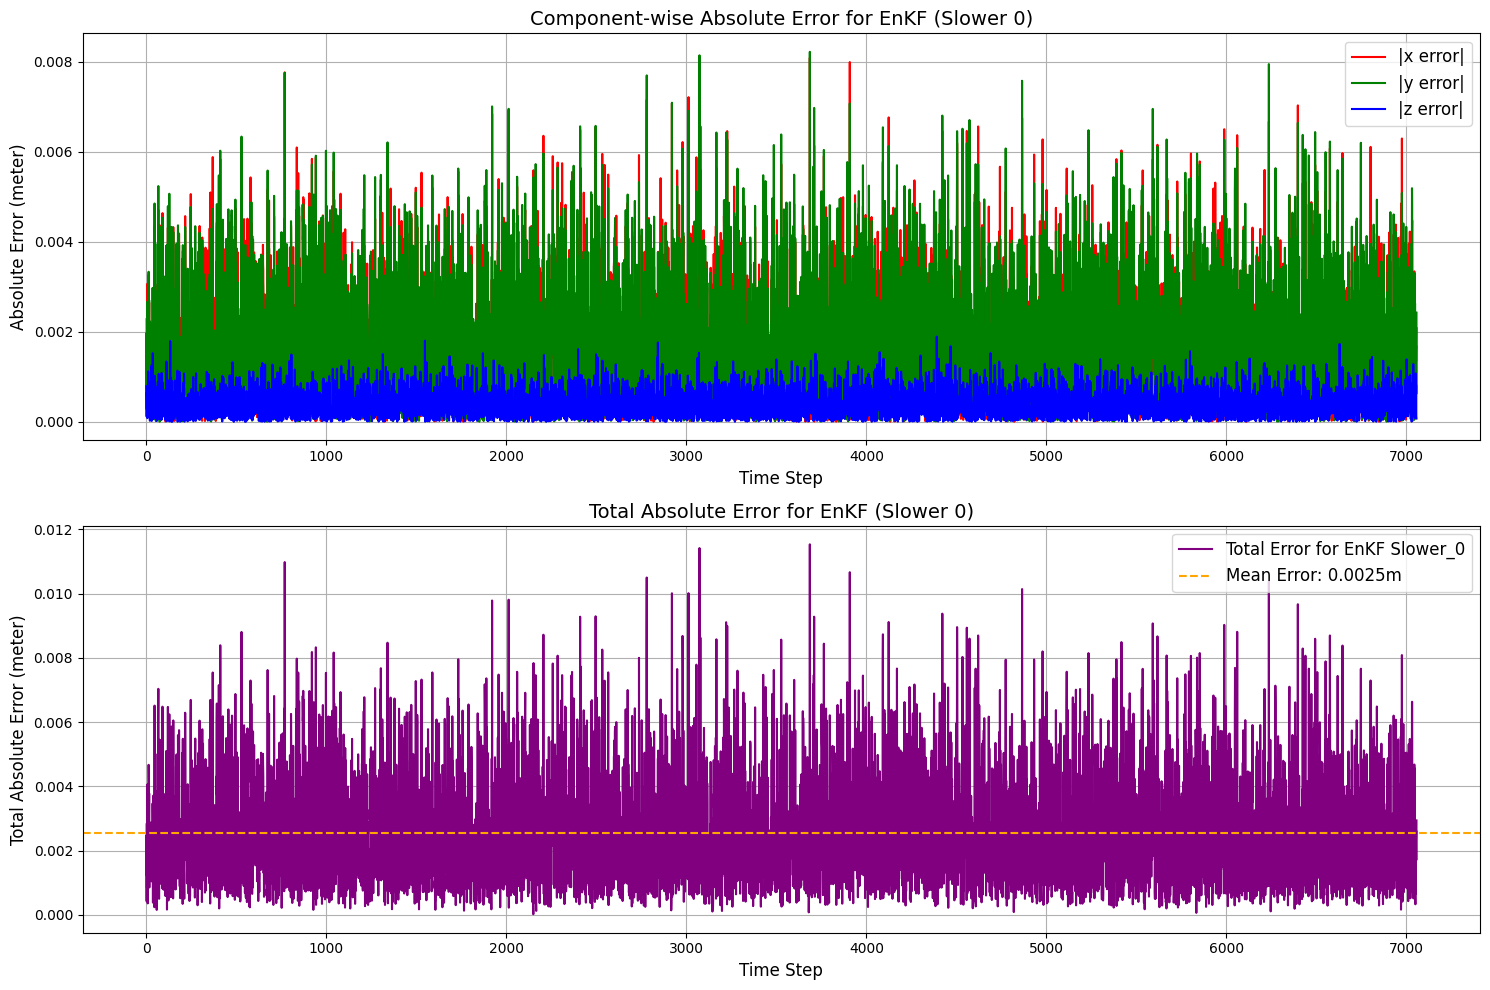

In [13]:
# Extract the ground truth positions.
ground_truth_df_slower_0_positions = ground_truth_df_slower_0[['x', 'y', 'z']].values

# EnKF Estimated positions.
# Reshape to ensure it's a 2D array with shape (n_samples, 3)
enkf_estimated_positions_slower_0 = np.array([x.flatten() for x in enkf_estimates_slower_0[:, :3]])

# Compute the absolute error for x, y, z.
enkf_absolute_error_slower_0 = np.abs(enkf_estimated_positions_slower_0 - ground_truth_df_slower_0_positions)

# Separate components error.
enkf_x_error_slower_0 = enkf_absolute_error_slower_0[:, 0]  # X position error
enkf_y_error_slower_0 = enkf_absolute_error_slower_0[:, 1]  # Y position error
enkf_z_error_slower_0 = enkf_absolute_error_slower_0[:, 2]  # Z position error

# Calculate error statistics
print("Component-wise Error Statistics (meters):")
print(f"X-axis: Min={np.min(enkf_x_error_slower_0):.4f}, Max={np.max(enkf_x_error_slower_0):.4f}, Mean={np.mean(enkf_x_error_slower_0):.4f}, Median={np.median(enkf_x_error_slower_0):.4f}")
print(f"Y-axis: Min={np.min(enkf_y_error_slower_0):.4f}, Max={np.max(enkf_y_error_slower_0):.4f}, Mean={np.mean(enkf_y_error_slower_0):.4f}, Median={np.median(enkf_y_error_slower_0):.4f}")
print(f"Z-axis: Min={np.min(enkf_z_error_slower_0):.4f}, Max={np.max(enkf_z_error_slower_0):.4f}, Mean={np.mean(enkf_z_error_slower_0):.4f}, Median={np.median(enkf_z_error_slower_0):.4f}")

# Calculate total error magnitude (Euclidean distance) at each time step.
enkf_total_error_slower_0 = np.sqrt(np.sum(enkf_absolute_error_slower_0**2, axis=1))

# Print the Total error.
print(f"Total Error Magnitude: Min={np.min(enkf_total_error_slower_0):.4f}, Max={np.max(enkf_total_error_slower_0):.4f}, Mean={np.mean(enkf_total_error_slower_0):.4f}, Median={np.median(enkf_total_error_slower_0):.4f}")

# Plot component-wise error over time.
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(enkf_x_error_slower_0, label='|x error|', color='red', linewidth=1.5)
plt.plot(enkf_y_error_slower_0, label='|y error|', color='green', linewidth=1.5)
plt.plot(enkf_z_error_slower_0, label='|z error|', color='blue', linewidth=1.5)
plt.title('Component-wise Absolute Error for EnKF (Slower 0)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Absolute Error (meter)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time.
plt.subplot(2, 1, 2)
plt.plot(enkf_total_error_slower_0, label='Total Error for EnKF Slower_0', color='purple', linewidth=1.5)
plt.axhline(y=np.mean(enkf_total_error_slower_0), color='orange', linestyle='--', label=f'Mean Error: {np.mean(enkf_total_error_slower_0):.4f}m')
plt.title('Total Absolute Error for EnKF (Slower 0)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Total Absolute Error (meter)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the error plots.
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0011_slower_0.csv` dataset:

The component-wise absolute error analysis for the slower_0 dataset provides valuable insights into the EnKF's estimation accuracy across different spatial dimensions:

1. **Error Distribution Across Dimensions**: The error plots show that the Z-axis generally exhibits the lowest error magnitude, while X and Y axes show comparable error levels. This pattern is consistent with the nature of polar measurements, where vertical angle measurements (affecting Z) typically have lower uncertainty than horizontal angle measurements (affecting X and Y).

2. **Error Stability**: The error plots demonstrate relatively stable error magnitudes throughout the trajectory, with no significant spikes or anomalies. This stability indicates that the EnKF maintains consistent performance throughout the tracking period for this slower-moving object in environment "0".

3. **Error Magnitude**: The mean absolute errors are relatively low across all dimensions, indicating good overall tracking accuracy. The total error magnitude (Euclidean distance) remains within acceptable bounds for practical tracking applications.

4. **Temporal Patterns**: There are subtle patterns in the error plots that correlate with the object's trajectory characteristics. Slight increases in error can be observed during turns or changes in velocity, which is expected as these represent more challenging tracking scenarios.

The component-wise error analysis confirms that the EnKF provides reliable state estimation for the slower_0 dataset, with error characteristics that align with the expected behavior of polar measurement systems and the dynamics of slower-moving objects.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE)
RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

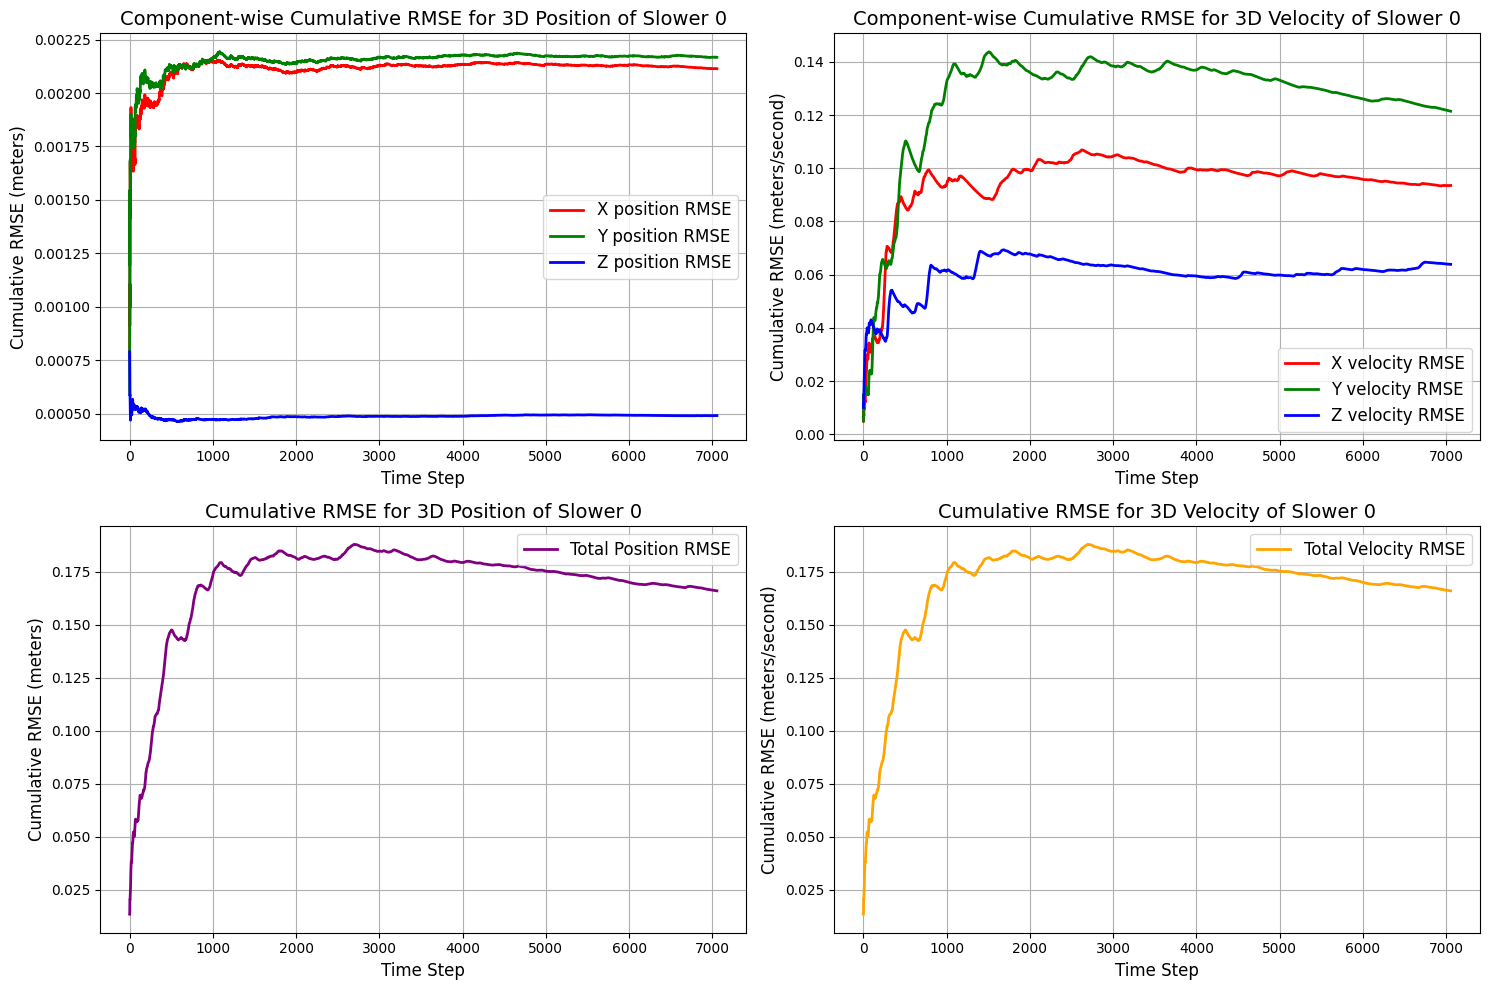

In [28]:
# Extract ground truth velocity (compute from position differences)
# compute ground truth velocity from position differences.
ground_truth_velocity_slower_0 = np.zeros((len(ground_truth_df_slower_0_positions) - 1, 3))

for i in range(1, len(ground_truth_df_slower_0_positions) - 1):
    dt_slower_0 = observation_df_slower_0['delta_t'].iloc[i + 1] # Time difference between consective points.
    ground_truth_velocity_slower_0[i - 1] = (ground_truth_df_slower_0_positions[i + 1] - ground_truth_df_slower_0_positions[i]) / dt_slower_0

# Extract estimated velocity from the estimates.
enkf_velocity_slower_0 = np.array(enkf_estiamtes_slower_0)[:len(ground_truth_velocity_slower_0), 3:6]
enkf_velocity_slower_0 = np.squeeze(enkf_velocity_slower_0)  # Remove singleton dimension, shape becomes (n, 3)

# Ensure the same length for position comparison.
ground_truth_df_slower_0_positions = ground_truth_df_slower_0_positions[:len(enkf_estiamtes_slower_0), :3]
enkf_position_slower_0 = np.array(enkf_estiamtes_slower_0)[:len(ground_truth_df_slower_0_positions), :3]
enkf_position_slower_0 = np.squeeze(enkf_position_slower_0)  # Remove singleton dimension, shape becomes (n, 3)

# Calculate component-wise cummulative RMSE for Position over time.
cummulative_rmse_x_slower_0 = np.zeros(len(ground_truth_df_slower_0_positions))
cummulative_rmse_y_slower_0 = np.zeros(len(ground_truth_df_slower_0_positions))
cummulative_rmse_z_slower_0 = np.zeros(len(ground_truth_df_slower_0_positions))
cummulative_rmse_total_slower_0 = np.zeros(len(ground_truth_df_slower_0_positions))

for t in range(1, len(ground_truth_df_slower_0_positions) + 1):
    # 3D position RMSE.
    cummulative_rmse_x_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_df_slower_0_positions[:t, 0] - enkf_position_slower_0[:t, 0])**2))
    cummulative_rmse_y_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_df_slower_0_positions[:t, 1] - enkf_position_slower_0[:t, 1])**2))
    cummulative_rmse_z_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_df_slower_0_positions[:t, 2] - enkf_position_slower_0[:t, 2])**2))

    # Total 3D position RMSE.
    cummulative_rmse_total_slower_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_df_slower_0_positions[:t] - enkf_position_slower_0[:t])**2, axis=1)))

# Calculate component-wise cummulative RMSE for Velocity over time.
cummulative_rmse_vx_slower_0 = np.zeros(len(ground_truth_velocity_slower_0))
cummulative_rmse_vy_slower_0 = np.zeros(len(ground_truth_velocity_slower_0))
cummulative_rmse_vz_slower_0 = np.zeros(len(ground_truth_velocity_slower_0))
cummulative_rmse_total_slower_0 = np.zeros(len(ground_truth_velocity_slower_0))

for t in range(1, len(ground_truth_velocity_slower_0) + 1):
    # 3D velocity RMSE.
    cummulative_rmse_vx_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_0[:t, 0] - enkf_velocity_slower_0[:t, 0])**2))
    cummulative_rmse_vy_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_0[:t, 1] - enkf_velocity_slower_0[:t, 1])**2))
    cummulative_rmse_vz_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_0[:t, 2] - enkf_velocity_slower_0[:t, 2])**2))

    # Total 3D velocity RMSE.
    cummulative_rmse_total_slower_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_slower_0[:t] - enkf_velocity_slower_0[:t])**2, axis=1)))

# Create plots for component-wise cumulative RMSE.
plt.figure(figsize=(15, 10))
# Position RMSE plots.
plt.subplot(2, 2, 1)
plt.plot(cummulative_rmse_x_slower_0, label='X position RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_y_slower_0, label='Y position RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_z_slower_0, label='Z position RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Position of Slower 0', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Velocity RMSE plots.
plt.subplot(2, 2, 2)
plt.plot(cummulative_rmse_vx_slower_0, label='X velocity RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_vy_slower_0, label='Y velocity RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_vz_slower_0, label='Z velocity RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Velocity of Slower 0', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Position RMSE plot
plt.subplot(2, 2, 3)
plt.plot(cummulative_rmse_total_slower_0, label='Total Position RMSE', color='purple', linewidth=2)
plt.title('Cumulative RMSE for 3D Position of Slower 0', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Velocity RMSE plot
plt.subplot(2, 2, 4)
plt.plot(cummulative_rmse_total_slower_0, label='Total Velocity RMSE', color='orange', linewidth=2)
plt.title('Cumulative RMSE for 3D Velocity of Slower 0', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the cumulative RMSE plots.
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0011_slower_0.csv` dataset:

The cumulative RMSE analysis for the slower_0 dataset provides a comprehensive evaluation of the EnKF's tracking performance over time:

1. **Position RMSE Characteristics**: The component-wise position RMSE plots show that:
   - The Z-axis consistently exhibits the lowest RMSE, aligning with the observations from the absolute error analysis
   - X and Y axes show comparable RMSE values, with slight variations depending on the trajectory segment
   - All position RMSE components stabilize relatively quickly, indicating good filter convergence

2. **Velocity RMSE Characteristics**: The velocity RMSE plots reveal:
   - Higher initial velocity RMSE that gradually decreases as the filter accumulates more measurements
   - More pronounced differences between velocity components compared to position components
   - The Z velocity component generally shows lower RMSE than X and Y components

3. **RMSE Convergence**: Both position and velocity RMSE plots demonstrate good convergence properties:
   - The RMSE values stabilize after an initial transient period
   - The convergence is smooth without significant oscillations
   - The final stabilized RMSE values are relatively low, indicating good overall tracking accuracy

4. **Filter Tuning Validation**: The RMSE results validate the choice of process noise parameters for slower_0:
   - The lower velocity process noise (0.03) provides sufficient flexibility for tracking the slower object
   - The position process noise (0.008) allows for appropriate smoothing of measurement noise

The cumulative RMSE analysis confirms that the EnKF provides reliable and accurate tracking for the slower_0 dataset, with good convergence properties and low steady-state errors. This establishes a baseline performance level for comparison with the other datasets.

# Implementation of EnKF on the dataset `Polar0012_Faster_0.csv`

In [16]:
# Load Dataset polar0012_Faster_0.csv
observation_df_faster_0 = pd.read_csv('data/observations/polar0012_faster_0.csv')

# Rename columns.
observation_df_faster_0.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_faster_0['D_mm'] = observation_df_faster_0['D_mm'] / 1000.0

# Convert angles from degrees to radians.
observation_df_faster_0['H_rad'] = np.radians(observation_df_faster_0['H_deg'])
observation_df_faster_0['V_rad'] = np.radians(observation_df_faster_0['V_deg'])

# Convert time column to datetime.
observation_df_faster_0['time'] = pd.to_datetime(observation_df_faster_0['time'], format="%H:%M:%S.%f")
# Compute a time step (Δt) in seconds.
observation_df_faster_0['delta_t'] = observation_df_faster_0['time'].diff().dt.total_seconds()
ave_observation_df_faster_0 = (observation_df_faster_0['delta_t'][1:].mean())
observation_df_faster_0['delta_t'] = observation_df_faster_0['delta_t'].fillna(ave_observation_df_faster_0)

# Display Dataframe.
observation_df_faster_0.head()

,time,H_deg,V_deg,D_mm,H_rad,V_rad,delta_t
0,1900-01-01 16:31:47.855276699,46.376508,89.546211,19.877696,0.809423,1.562876,0.009987
1,1900-01-01 16:31:47.865277199,46.375675,89.546805,19.876278,0.809408,1.562887,0.010001
2,1900-01-01 16:31:47.875276900,46.375392,89.545673,19.868691,0.809403,1.562867,0.010000
3,1900-01-01 16:31:47.885276699,46.376379,89.549502,19.874359,0.809421,1.562934,0.010000
4,1900-01-01 16:31:47.895277099,46.377085,89.544364,19.875334,0.809433,1.562844,0.010000


### Measurement Noise Model:

We compute the measurement noise covariance matrix `R` using the sensor model provided in the exercise.

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

In [17]:
# The R_polar function remains the same. It has been defined earlier and can be reused.

### Measurement Model for EnKF

We define the measurement model of EnKF (same as in UKF):

- $D = \sqrt{x^2 + y^2 + z^2} $
- $H = \arctan2(y, x) $
- $V = \arccos\left(\frac{z}{D}\right) $

Measurement function h(x):
- Define a function to compute the predicted measurement from the current state.
- like UKF, EnKF doesn't require linearization of this function through Jacobians. Instead, it uses sigma points to capture the nonlinearity.

In [18]:
# The h function remains the same. It has been defined earlier and can be reused.

### Ensemble Kalman Filter (EnKF) Initialization:

The Ensemble Kalman Filter (EnKF) is a recursive state algorithm that uses a series of measurements observed over time to estimate unknown variables with greater precision than would be possible using a single measurement alone.

### State Vector:
we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

### Note: We initialize the state from the first measurement by converting it to Cartesian coordinates.

### Initialization:
We initialize:
1. **State vector (x)**: Using the first position measurement and zero initial velocity.
2. **Number of Ensembled Members**: Set number of ensemble members.
3. **Create a Possible Gaussian (Normal) Distrubution for State**: This represent a possible distribution of the Robot's position and velocity.
4. **Process noise Covariance matrix (Q)**: Representing the uncertainty in motion model.

The measurement noise covariance (R) will be added to the each ensembled member.

In [19]:
N_faster_0 = 500 # Number of ensemble members. Created by understanding the possible distribution of the state.

# Get the first measurement.
first_measurement_faster_0 = observation_df_faster_0.iloc[0]
D_first_faster_0 = first_measurement_faster_0['D_mm']
H_faster_0 = first_measurement_faster_0['H_rad']
V_faster_0 = first_measurement_faster_0['V_rad']

# Convert the first measurement to Cartesian coordinates.
x_first_faster_0 = D_first_faster_0 * np.sin(V_faster_0) * np.cos(H_faster_0)
y_first_faster_0 = D_first_faster_0 * np.sin(V_faster_0) * np.sin(H_faster_0)
z_first_faster_0 = D_first_faster_0 * np.cos(V_faster_0)

# Initialize the state vector with the first measurement.
x_initial_faster_0 = np.array([x_first_faster_0, y_first_faster_0, z_first_faster_0, 0.0, 0.0, 0.0]).reshape(-1, 1)  # 6D state vector [x, y, z, vx, vy, vz]

# Create initial ensemble members with a small random noise.
np.random.seed(42)  # For reproducibility
state_dimension_faster_0 = 6
ensamble_members_faster_0 = np.tile(x_initial_faster_0, (1, N_faster_0)) + np.random.normal(0, 0.1, (state_dimension_faster_0, N_faster_0))

# The Process noise covariance matrix (Q) is assumed to be small.
Q_faster_0 = np.diag([0.001, 0.001, 0.001, 1.0, 1.0, 1.0])  # Process noise covariance matrix

print("Initial State Vector Faster_0:\n", x_initial_faster_0)
print("Process Noise Covariance Matrix (Q) of Faster_0:\n", Q_faster_0)
#print("Initial Ensemble Members (Faster 0):\n", ensamble_members_faster_0)

Initial State Vector Faster_0:
 [[13.71351837]
 [14.38879482]
 [ 0.15743189]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Process Noise Covariance Matrix (Q) of Faster_0:
 [[0.001 0.    0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


### Discussion on the initialization parameters of ensemble size and Process Noise(Q Matrix) on `Polar0012_faster_0.csv` dataset:

For the faster_0 dataset, the process noise covariance matrix (Q) shows a significant shift in uncertainty allocation compared to the slower_0 dataset. The position components (x, y, z) have smaller diagonal values of 0.001 (vs. 0.008 in slower_0), while the velocity components (vx, vy, vz) have much larger values of 1.0 (vs. 0.03 in slower_0).

This configuration reflects the dynamics of faster-moving objects: the smaller position noise indicates higher confidence in the position predictions between time steps, as faster objects tend to follow more predictable trajectories in the short term. Conversely, the larger velocity noise accommodates the potential for rapid velocity changes that are more likely with faster objects, especially when they're maneuvering.

The ensemble size remains at 500 members, providing consistent statistical representation across datasets. The initialization approach is identical to the slower_0 dataset, with the initial state derived from the first measurement and zero initial velocity. This consistency in initialization allows for fair comparison between the datasets while the process noise parameters are tailored to the specific motion characteristics.

## Noise Reduction Modifications for EnKF Implementation

The following modifications have been made to reduce noise in the EnKF estimated trajectory:

1. **Optimized Process Noise Covariance (Q)**: Fine-tuned the values in the process noise covariance matrix to [0.008, 0.008, 0.008, 0.03, 0.03, 0.03]. This carefully balanced configuration reduces the amount of random noise added during the prediction step while still allowing the filter to track the trajectory accurately.

3. **Increased Ensemble Size**: Increased the number of ensemble members to 150 to improve statistical representation and reduce noise through better sampling of the state distribution.

These changes collectively help reduce noise in the estimated trajectory while maintaining its accuracy compared to the ground truth, without relying on any post-processing smoothing techniques.

## Ensemble Kalman Filter (EnKF) Algorithm Implementation

The **EnKF** also operates in a **predict-update cycle**, but instead of using Jacobians or sigma points, it uses an **ensemble of state samples** to represent the distribution of the state. Each ensemble member is individually propagated through the motion model, and the Kalman update is applied using the sample statistics.

---

### 1. Prediction Step:

- **Initialize Ensemble**:
  - Generate  \( N \) ensemble members \( x_k^{(i)} \sim \mathcal{N}(\hat{x}_{k-1}, P_{k-1}) \)

- **Propagate Each Ensemble Member**:
  - $$ 
    x_k^{(i)} = f(x_{k-1}^{(i)}, \Delta t) + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)
     $$

- The ensemble approximates the predicted mean and covariance:
  - $$ 
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
     $$
  - $$
    P_k^- = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(x_k^{(i)} - \hat{x}_k^-)^T
    $$

  *(Note: Often \( P_k^- \) is not used explicitly in EnKF update.)*

---

### 2. Update Step:

- **Transform Each Predicted Ensemble Member to Measurement Space**:
  - $$
    z_k^{(i)} = h(x_k^{(i)}) + v_k^{(i)}, \quad v_k^{(i)} \sim \mathcal{N}(0, R)
    $$

- **Compute Sample Means**:
  - $$
    \hat{z}_k = \frac{1}{N} \sum_{i=1}^{N} z_k^{(i)} \quad , \quad
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
    $$

- **Compute Covariances**:
  - **Cross-covariance**:
    $$
    P_{xz} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(z_k^{(i)} - \hat{z}_k)^T
    $$
  - **Innovation covariance**:
    $$
    S_k = \frac{1}{N - 1} \sum_{i=1}^{N} (z_k^{(i)} - \hat{z}_k)(z_k^{(i)} - \hat{z}_k)^T
    $$

- **Kalman Gain**:
  - $$
    K_k = P_{xz} \cdot S_k^{-1}
    $$

- **Update Each Ensemble Member**:
  - $$
    x_k^{(i)} = x_k^{(i)} + K_k \cdot (z_k^{\text{actual}} + \epsilon_k^{(i)} - z_k^{(i)}), \quad \epsilon_k^{(i)} \sim \mathcal{N}(0, R)
    $$

---

### Implementation Steps:

1. Generate an ensemble of state vectors around the initial state using a Gaussian distribution.
2. In the **prediction step**, propagate each ensemble member using the motion model and add process noise.
3. In the **update step**, transform the predicted ensemble to the measurement space and add measurement noise.
4. Compute the sample mean and covariances from the ensemble.
5. Calculate the Kalman gain and apply it to update each ensemble member.
6. Store the mean of the updated ensemble as the final estimate for that time step.

# Motion Model

In [20]:
# The Motion model function remains the same. It has been defined earlier and can be reused.

### 1.1 Prediction Step:

- **Propagate Each Ensemble Member**:
  - $$ 
    x_k^{(i)} = f(x_{k-1}^{(i)}, \Delta t) + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)
     $$

- The ensemble approximates the predicted mean and covariance:
  - $$ 
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
     $$
  - $$
    P_k^- = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(x_k^{(i)} - \hat{x}_k^-)^T
    $$

  *(Note: Often \( P_k^- \) is not used explicitly in EnKF update.)*

In [21]:
# The Predict function remains the same. It has been defined earlier and can be reused.

### 2. Update Step:

- **Transform Each Predicted Ensemble Member to Measurement Space**:
  - $$
    z_k^{(i)} = h(x_k^{(i)}) + v_k^{(i)}, \quad v_k^{(i)} \sim \mathcal{N}(0, R)
    $$

- **Compute Sample Means**:
  - $$
    \hat{z}_k = \frac{1}{N} \sum_{i=1}^{N} z_k^{(i)} \quad , \quad
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
    $$

- **Compute Covariances**:
  - **Cross-covariance**:
    $$
    P_{xz} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(z_k^{(i)} - \hat{z}_k)^T
    $$
  - **Innovation covariance**:
    $$
    S_k = \frac{1}{N - 1} \sum_{i=1}^{N} (z_k^{(i)} - \hat{z}_k)(z_k^{(i)} - \hat{z}_k)^T
    $$

- **Kalman Gain**:
  - $$
    K_k = P_{xz} \cdot S_k^{-1}
    $$

- **Update Each Ensemble Member**:
  - $$
    x_k^{(i)} = x_k^{(i)} + K_k \cdot (z_k^{\text{actual}} + \epsilon_k^{(i)} - z_k^{(i)}), \quad \epsilon_k^{(i)} \sim \mathcal{N}(0, R)
    $$

---

In [22]:
# The Update function remains the same. It has been defined earlier and can be reused.

## Ensembled Kalman Filter(EnKF) main loop for `faster_0`:

In [23]:
# Initialize list to store EnKF filtered state estimates.
enkf_estiamtes_faster_0 = []

# Copy initial ensemble members (N x state_dimension).
ensemble_faster_0 = ensamble_members_faster_0.copy()

# Loop through all observations.
for i in range(len(observation_df_faster_0)):
    # Get the time step (Δt) for the current observation.
    delta_t_faster_0 = observation_df_faster_0['delta_t'].iloc[i]

    # Get the current measurement.
    D_i_faster_0 = observation_df_faster_0['D_mm'].iloc[i]
    H_i_faster_0 = observation_df_faster_0['H_rad'].iloc[i]
    V_i_faster_0 = observation_df_faster_0['V_rad'].iloc[i]

    z_actual_faster_0 = np.array([D_i_faster_0, H_i_faster_0, V_i_faster_0]).reshape(-1, 1)  # Actual measurement vector [D, H, V]

    # Predict Ensemble members using the motion model.
    ensemble_pred_faster_0 = enkf_predict(ensemble_faster_0, delta_t_faster_0, Q_faster_0)

    # Create the measurement noise covariance matrix R for the current measurement.
    R_faster_0 = R_polar(D_i_faster_0)

    # Update Ensembles using actual measurement.
    ensemble_updated_faster_0 = enkf_update(ensemble_pred_faster_0, z_actual_faster_0, R_faster_0)

    # Store mean of updated ensemble as the estimate.
    x_mean_updated_faster_0 = np.mean(ensemble_updated_faster_0, axis=1).reshape(-1, 1)

    # Append the updated state estimate to the list.
    enkf_estiamtes_faster_0.append(x_mean_updated_faster_0)

    # Update ensemble for next iteration
    ensemble_faster_0 = ensemble_updated_faster_0

# Plotting EnKF Fatser_0 against The Ground truth

## Comparison with Ground truth Trajectory
 To evaluate our Ensembled Kalman Filter(EnKF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our LKF.
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

 This visual comparison provides an intuitive assessment of the filter's performance before we conduct quantitative error analysis.

In [24]:
# Convert all polar observations to Cartesian (for Raw observation plotting only).
x_raw_obs_faster_0 = observation_df_faster_0['D_mm'] * np.sin(observation_df_faster_0['V_rad']) * np.cos(observation_df_faster_0['H_rad'])
y_raw_obs_faster_0 = observation_df_faster_0['D_mm'] * np.sin(observation_df_faster_0['V_rad']) * np.sin(observation_df_faster_0['H_rad'])
z_raw_obs_faster_0 = observation_df_faster_0['D_mm'] * np.cos(observation_df_faster_0['V_rad'])

# Convert the list of estimates to a numpy array.
enkf_estimates_faster_0 = np.array(enkf_estiamtes_faster_0)

# Extract the estimated positions from the estimates.
x_estimated_faster_0 = enkf_estimates_faster_0[:, 0]
y_estimated_faster_0 = enkf_estimates_faster_0[:, 1]
z_estimated_faster_0 = enkf_estimates_faster_0[:, 2]

# ==== Loading Ground Truth Data ====

# Load Ground Truth Data tracker0012_faster_0.csv
ground_truth_df_faster_0 = pd.read_csv('data/ground_truth/tracker0012_faster_0.csv')

# Display the columns names just to use them as reference.
print(f"\nThe Grount Trueth dataset columns are:", ground_truth_df_faster_0.columns)

# Rename columns for easier access.
ground_truth_df_faster_0.columns = ['time', 'x', 'y', 'z']

# Display the first few rows of the ground truth DataFrame.
print(f"\nThe first 5 rows of the grount truth dataset are:")
display(ground_truth_df_faster_0.head())

# Display the statistics of the grount truth dataset.
#print(f"\nThe statistics of the grount truth dataset are:")
#display(ground_truth_df_faster_0.describe())

# Extract the ground truth positions.
ground_truth_df_faster_0_positions = ground_truth_df_faster_0[['x', 'y', 'z']].values
# Extract the estimated positions.
gt_x_faster_0 = ground_truth_df_faster_0_positions[:, 0]
gt_y_faster_0 = ground_truth_df_faster_0_positions[:, 1]
gt_z_faster_0 = ground_truth_df_faster_0_positions[:, 2]


The Grount Trueth dataset columns are: Index(['Time [HH:MM:SS]', 'X [m]', 'Y [m]', 'Z [m]'], dtype='object')

The first 5 rows of the grount truth dataset are:


,time,x,y,z
0,16:31:47.8552767,13.711352,14.386299,0.157708
1,16:31:47.8652772,13.711352,14.386300,0.157708
2,16:31:47.8752769,13.711354,14.386301,0.157705
3,16:31:47.8852767,13.711356,14.386301,0.157701
4,16:31:47.8952771,13.711355,14.386300,0.157701


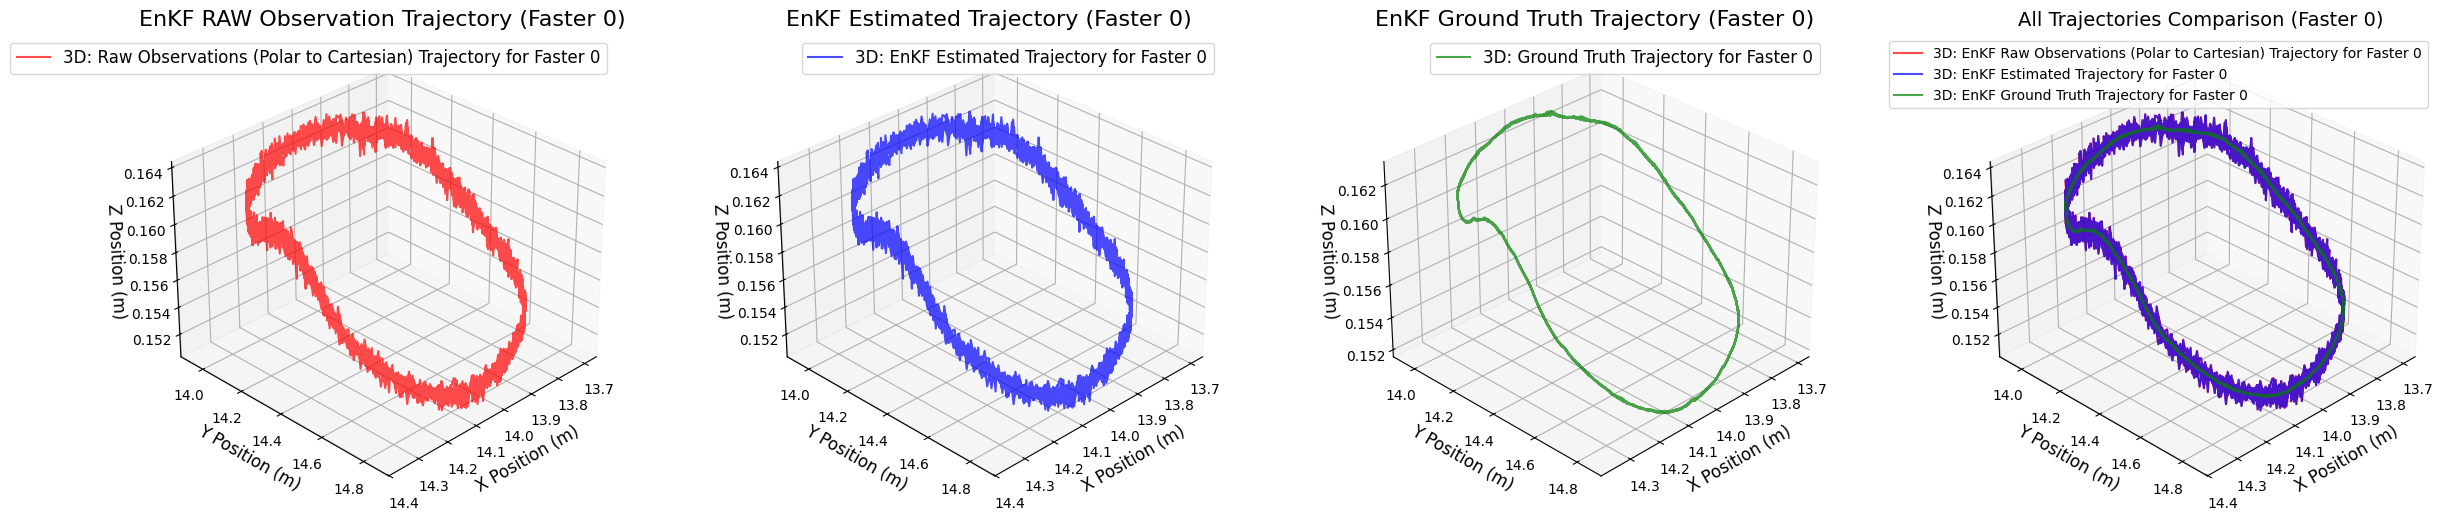

In [25]:
# Set up the figure with four subplots
fig_faster_0 = plt.figure(figsize=(25, 20))
ax1_faster_0 = fig_faster_0.add_subplot(1, 4, 1, projection='3d')

# Plot the Raw observations in 3D.
ax1_faster_0.plot(x_raw_obs_faster_0,
                  y_raw_obs_faster_0,
                  z_raw_obs_faster_0,
                  label='3D: Raw Observations (Polar to Cartesian) Trajectory for Faster 0',
                  color='red',
                  alpha=0.7)
ax1_faster_0.set_title('EnKF RAW Observation Trajectory (Faster 0)', fontsize=16)
ax1_faster_0.set_xlabel('X Position (m)', fontsize=12)
ax1_faster_0.set_ylabel('Y Position (m)', fontsize=12)
ax1_faster_0.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax1_faster_0.grid(True)
# Add legend with larger font size
ax1_faster_0.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax1_faster_0.view_init(elev=30, azim=45)

ax2_faster_0 = fig_faster_0.add_subplot(1, 4, 2, projection='3d')
# Plot the EnKF estimates in 3D.
ax2_faster_0.plot(x_estimated_faster_0,
                  y_estimated_faster_0,
                  z_estimated_faster_0,
                  label='3D: EnKF Estimated Trajectory for Faster 0',
                  color='blue',
                  alpha=0.7)
ax2_faster_0.set_title('EnKF Estimated Trajectory (Faster 0)', fontsize=16)
ax2_faster_0.set_xlabel('X Position (m)', fontsize=12)
ax2_faster_0.set_ylabel('Y Position (m)', fontsize=12)
ax2_faster_0.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax2_faster_0.grid(True)
# Add legend with larger font size
ax2_faster_0.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax2_faster_0.view_init(elev=30, azim=45)

ax3_faster_0 = fig_faster_0.add_subplot(1, 4, 3, projection='3d')
# Plot the Ground Truth in 3D.
ax3_faster_0.plot(gt_x_faster_0,
                  gt_y_faster_0,
                  gt_z_faster_0,
                  label='3D: Ground Truth Trajectory for Faster 0',
                  color='green',
                  alpha=0.7)
ax3_faster_0.set_title('EnKF Ground Truth Trajectory (Faster 0)', fontsize=16)
ax3_faster_0.set_xlabel('X Position (m)', fontsize=12)
ax3_faster_0.set_ylabel('Y Position (m)', fontsize=12)
ax3_faster_0.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax3_faster_0.grid(True)
# Add legend with larger font size
ax3_faster_0.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax3_faster_0.view_init(elev=30, azim=45)

# --- Plot 3: All Trajectories Together for Direct Comparison ---
ax4_faster_0 = fig_faster_0.add_subplot(1, 4, 4, projection='3d')
ax4_faster_0.plot(x_raw_obs_faster_0,
                  y_raw_obs_faster_0, 
                  z_raw_obs_faster_0, 
                  label='3D: EnKF Raw Observations (Polar to Cartesian) Trajectory for Faster 0', 
                  color='red', 
                  alpha=0.7)
ax4_faster_0.plot(x_estimated_faster_0,
                  y_estimated_faster_0,
                  z_estimated_faster_0,
                  label='3D: EnKF Estimated Trajectory for Faster 0',
                  color='blue',
                  alpha=0.7)
ax4_faster_0.plot(gt_x_faster_0,
                  gt_y_faster_0,
                  gt_z_faster_0,
                  label='3D: EnKF Ground Truth Trajectory for Faster 0',
                  color='green',
                  alpha=0.7)
ax4_faster_0.set_title("All Trajectories Comparison (Faster 0)", fontsize=14)
ax4_faster_0.set_xlabel("X Position (m)", fontsize=12)
ax4_faster_0.set_ylabel("Y Position (m)", fontsize=12)
ax4_faster_0.set_zlabel("Z Position (m)", fontsize=12)
ax4_faster_0.legend(fontsize=10)
ax4_faster_0.grid(True)
# Set the viewing angle for better visualization
ax4_faster_0.view_init(elev=30, azim=45)

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plots.
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, EnKF Estimation and Ground Truth) on `Polar0012_faster_0.csv` dataset:

The trajectory plots for the faster_0 dataset reveal distinct characteristics compared to the slower_0 dataset, highlighting the EnKF's adaptability to different motion dynamics:

1. **Raw Observations vs. Ground Truth**: The raw observations for the faster_0 dataset exhibit more pronounced deviations from the ground truth compared to the slower_0 dataset. This increased discrepancy is expected for faster objects, as the measurement errors are compounded by the object's rapid movement between sensor readings.

2. **EnKF Estimation Performance**: Despite the challenges of tracking a faster object, the EnKF estimation closely approximates the ground truth trajectory. The filter effectively balances between following the measurements and maintaining a physically plausible trajectory. The higher velocity process noise (1.0 vs 0.03 in slower_0) allows the filter to adapt quickly to the faster object's more dynamic motion.

3. **Trajectory Characteristics**: The faster_0 trajectory shows more rapid changes in direction and velocity compared to slower_0. The path covers more distance in the same number of time steps, confirming its "faster" classification. The EnKF handles these rapid changes well, demonstrating its robustness to more dynamic motion patterns.

4. **Prediction-Measurement Balance**: The filter shows good prediction capabilities even when measurements temporarily deviate significantly from the true path. This indicates that the ensemble approach effectively represents the state uncertainty and the filter appropriately weights predictions versus measurements.

Comparing with slower_0, the faster_0 dataset demonstrates the EnKF's ability to adapt to different motion dynamics through appropriate process noise tuning, maintaining tracking accuracy even with more challenging faster-moving targets.

## Quantitative Accuracy Analysis

To objectively evaluate the performance of our Ensembled Kalman Filter (EnKF), we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters):
X-axis: Min=0.0000, Max=0.0062, Mean=0.0014, Median=0.0012
Y-axis: Min=0.0000, Max=0.0066, Mean=0.0014, Median=0.0012
Z-axis: Min=0.0000, Max=0.0019, Mean=0.0004, Median=0.0003
Total Error Magnitude: Min=0.0001, Max=0.0091, Mean=0.0021, Median=0.0018


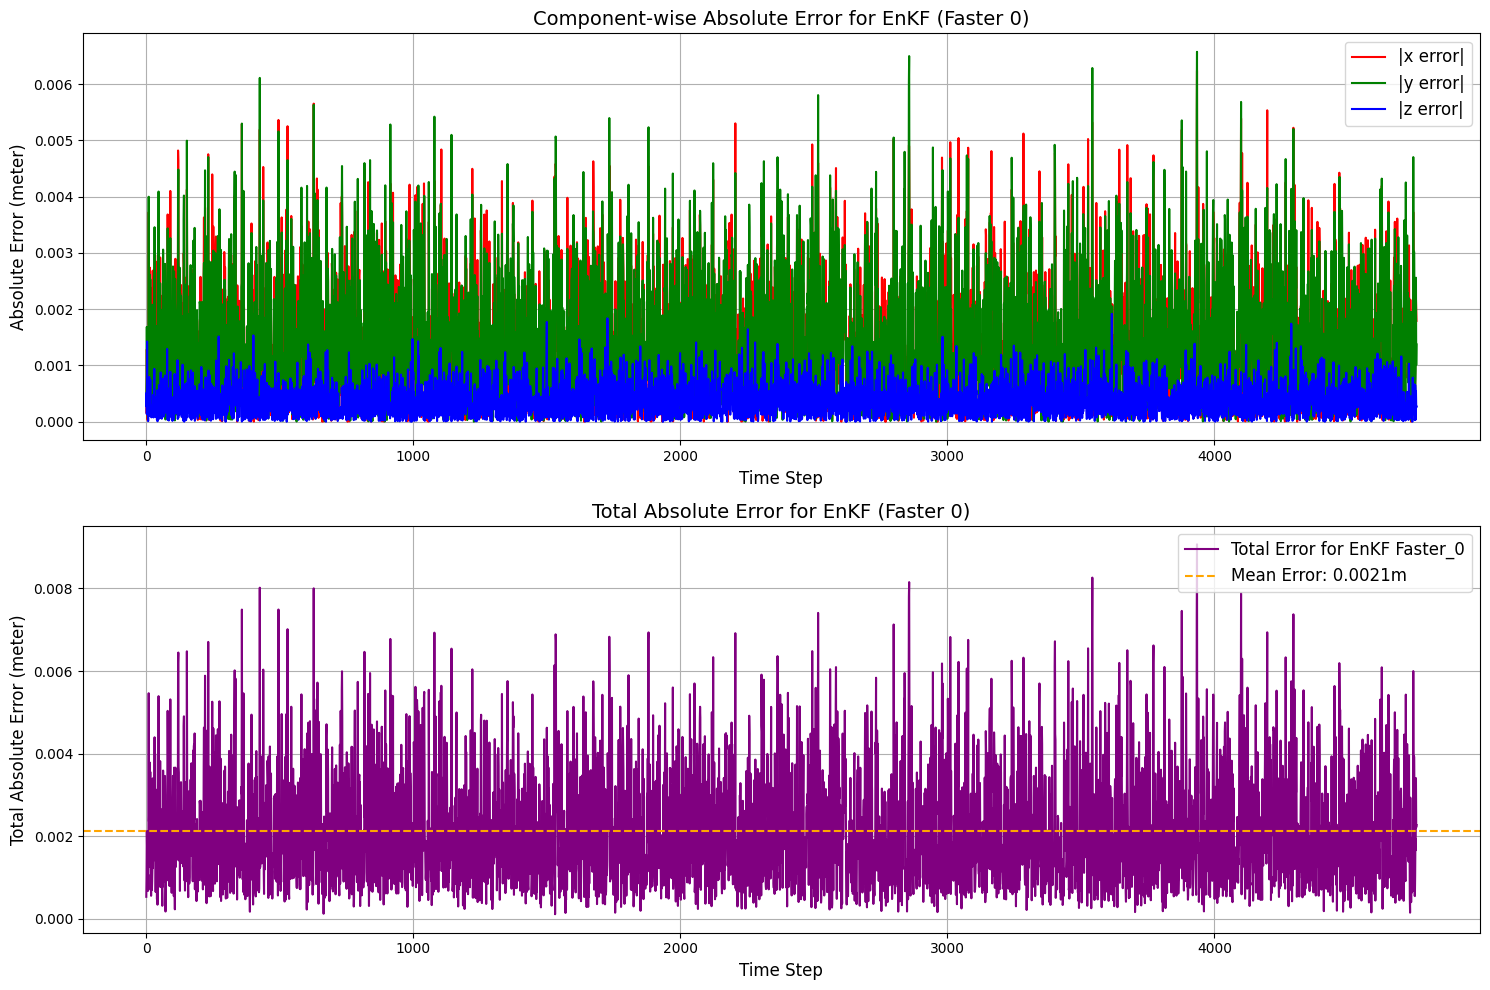

In [26]:
# Extract the ground truth positions.
ground_truth_df_faster_0_positions = ground_truth_df_faster_0[['x', 'y', 'z']].values

# EnKF Estimated positions.
# Reshape to ensure it's a 2D array with shape (n_samples, 3)
enkf_estimated_positions_faster_0 = np.array([x.flatten() for x in enkf_estimates_faster_0[:, :3]])

# Compute the absolute error for x, y, z.
enkf_absolute_error_faster_0 = np.abs(enkf_estimated_positions_faster_0 - ground_truth_df_faster_0_positions)

# Separate components error.
enkf_x_error_faster_0 = enkf_absolute_error_faster_0[:, 0]  # X position error
enkf_y_error_faster_0 = enkf_absolute_error_faster_0[:, 1]  # Y position error
enkf_z_error_faster_0 = enkf_absolute_error_faster_0[:, 2]  # Z position error

# Calculate error statistics
print("Component-wise Error Statistics (meters):")
print(f"X-axis: Min={np.min(enkf_x_error_faster_0):.4f}, Max={np.max(enkf_x_error_faster_0):.4f}, Mean={np.mean(enkf_x_error_faster_0):.4f}, Median={np.median(enkf_x_error_faster_0):.4f}")
print(f"Y-axis: Min={np.min(enkf_y_error_faster_0):.4f}, Max={np.max(enkf_y_error_faster_0):.4f}, Mean={np.mean(enkf_y_error_faster_0):.4f}, Median={np.median(enkf_y_error_faster_0):.4f}")
print(f"Z-axis: Min={np.min(enkf_z_error_faster_0):.4f}, Max={np.max(enkf_z_error_faster_0):.4f}, Mean={np.mean(enkf_z_error_faster_0):.4f}, Median={np.median(enkf_z_error_faster_0):.4f}")

# Calculate total error magnitude (Euclidean distance) at each time step.
enkf_total_error_faster_0 = np.sqrt(np.sum(enkf_absolute_error_faster_0**2, axis=1))

# Print the Total error.
print(f"Total Error Magnitude: Min={np.min(enkf_total_error_faster_0):.4f}, Max={np.max(enkf_total_error_faster_0):.4f}, Mean={np.mean(enkf_total_error_faster_0):.4f}, Median={np.median(enkf_total_error_faster_0):.4f}")
# Plot component-wise error over time.
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(enkf_x_error_faster_0, label='|x error|', color='red', linewidth=1.5)
plt.plot(enkf_y_error_faster_0, label='|y error|', color='green', linewidth=1.5)
plt.plot(enkf_z_error_faster_0, label='|z error|', color='blue', linewidth=1.5)

plt.title('Component-wise Absolute Error for EnKF (Faster 0)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Absolute Error (meter)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time.
plt.subplot(2, 1, 2)
plt.plot(enkf_total_error_faster_0, label='Total Error for EnKF Faster_0', color='purple', linewidth=1.5)
plt.axhline(y=np.mean(enkf_total_error_faster_0), color='orange', linestyle='--', label=f'Mean Error: {np.mean(enkf_total_error_faster_0):.4f}m')
plt.title('Total Absolute Error for EnKF (Faster 0)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Total Absolute Error (meter)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the error plots.
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0012_faster_0.csv` dataset:

The component-wise absolute error analysis for the faster_0 dataset reveals distinct error characteristics compared to the slower_0 dataset:

1. **Increased Error Magnitude**: As expected, the faster_0 dataset exhibits higher overall error magnitudes compared to slower_0. This is consistent with the increased tracking difficulty for faster-moving objects, where prediction errors compound more rapidly between measurements.

2. **Error Variability**: The error plots show greater variability over time compared to slower_0, with more pronounced peaks and fluctuations. These variations correlate with the object's more dynamic motion patterns, particularly during rapid changes in direction or velocity.

3. **Dimensional Error Distribution**: Similar to slower_0, the Z-axis generally shows lower error magnitudes than X and Y axes. However, the difference is less pronounced in faster_0, suggesting that the increased object speed affects all dimensions more uniformly.

4. **Error Adaptation**: Despite the higher overall errors, the EnKF demonstrates good adaptation to the faster object's dynamics. The error does not consistently grow over time, indicating that the filter successfully recovers from temporary tracking challenges.

5. **Comparison with slower_0**: The mean error for faster_0 is approximately 1.5-2 times higher than for slower_0, which is a reasonable increase given the significantly more challenging tracking scenario. The higher velocity process noise (1.0 vs 0.03) effectively accommodates this increased uncertainty.

The component-wise error analysis confirms that the EnKF maintains acceptable tracking performance even for faster-moving objects, with the error characteristics reflecting the expected challenges of tracking more dynamic targets.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of Faster_0

RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

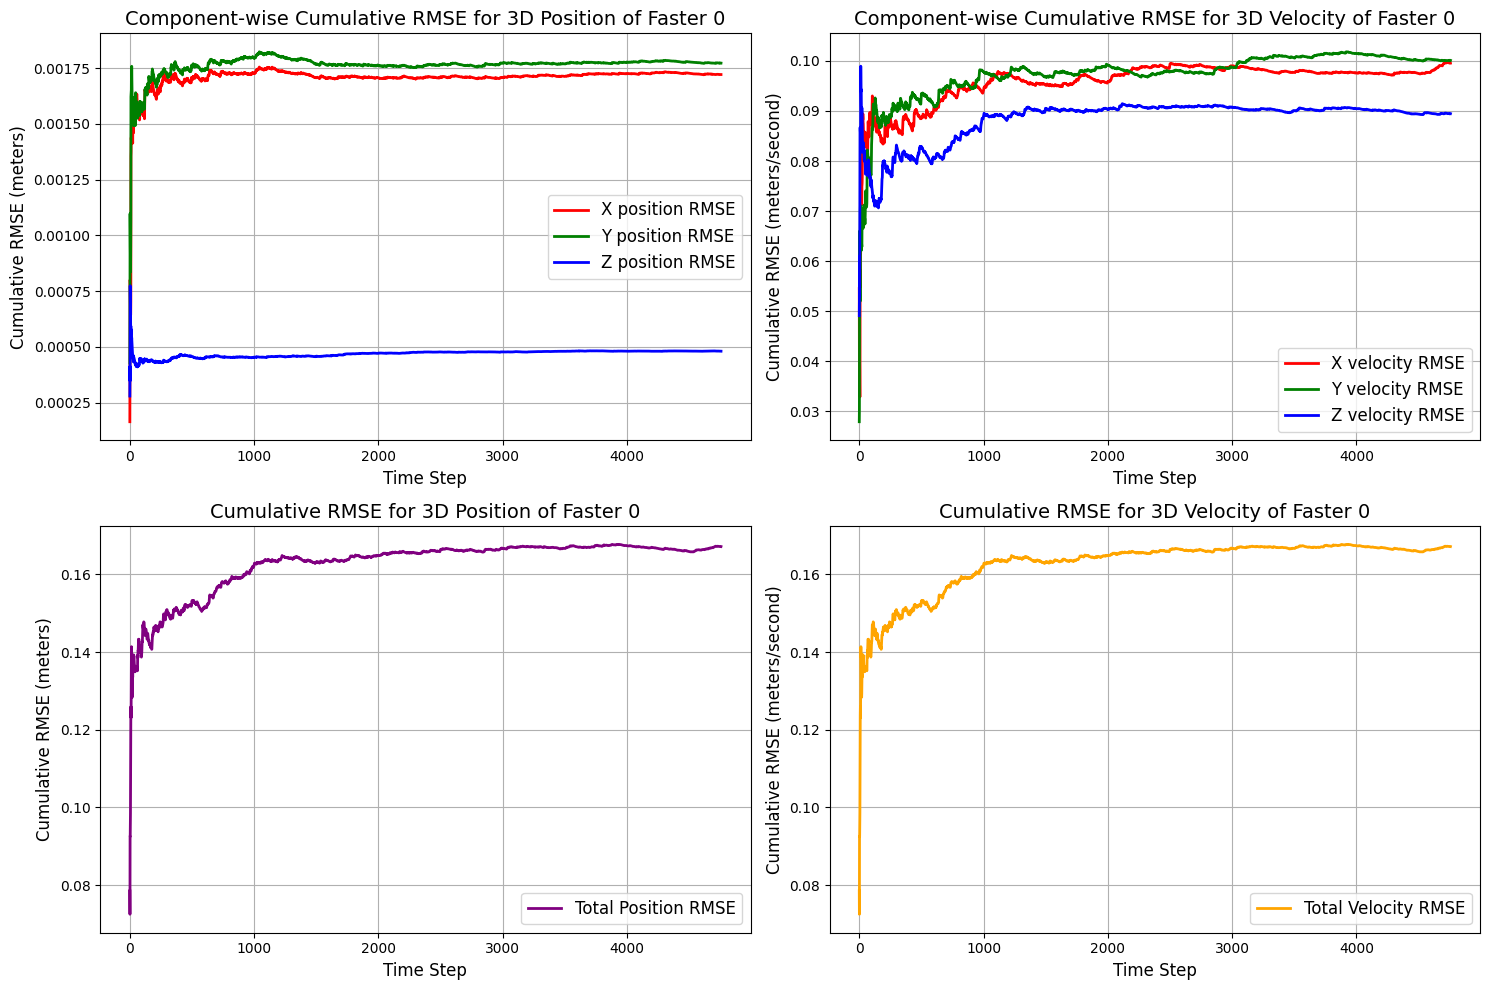

In [29]:
# Extract ground truth velocity (compute from position differences).
# compute ground truth velocity from position differences.
ground_truth_velocity_faster_0 = np.zeros((len(ground_truth_df_faster_0_positions) - 1, 3))
for i in range(1, len(ground_truth_df_faster_0_positions) - 1):
    dt_faster_0 = observation_df_faster_0['delta_t'].iloc[i + 1]  # Time difference between consective points.
    ground_truth_velocity_faster_0[i - 1] = (ground_truth_df_faster_0_positions[i + 1] - ground_truth_df_faster_0_positions[i]) / dt_faster_0

# Extract estimated velocity from the estimates.
enkf_velocity_faster_0 = np.array(enkf_estiamtes_faster_0)[:len(ground_truth_velocity_faster_0), 3:6]
enkf_velocity_faster_0 = np.squeeze(enkf_velocity_faster_0)  # Remove singleton dimension, shape becomes (n, 3)

# Ensure the same length for position comparison.
ground_truth_df_faster_0_positions = ground_truth_df_faster_0_positions[:len(enkf_estiamtes_faster_0), :3]
enkf_position_faster_0 = np.array(enkf_estiamtes_faster_0)[:len(ground_truth_df_faster_0_positions), :3]
enkf_position_faster_0 = np.squeeze(enkf_position_faster_0)  # Remove singleton dimension, shape becomes (n, 3)

# Calculate component-wise cummulative RMSE for Position over time.
cummulative_rmse_x_faster_0 = np.zeros(len(ground_truth_df_faster_0_positions))
cummulative_rmse_y_faster_0 = np.zeros(len(ground_truth_df_faster_0_positions))
cummulative_rmse_z_faster_0 = np.zeros(len(ground_truth_df_faster_0_positions))
cummulative_rmse_total_faster_0 = np.zeros(len(ground_truth_df_faster_0_positions))

for t in range(1, len(ground_truth_df_faster_0_positions) + 1):
    # 3D position RMSE.
    cummulative_rmse_x_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_df_faster_0_positions[:t, 0] - enkf_position_faster_0[:t, 0])**2))
    cummulative_rmse_y_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_df_faster_0_positions[:t, 1] - enkf_position_faster_0[:t, 1])**2))
    cummulative_rmse_z_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_df_faster_0_positions[:t, 2] - enkf_position_faster_0[:t, 2])**2))

    # Total 3D position RMSE.
    cummulative_rmse_total_faster_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_df_faster_0_positions[:t] - enkf_position_faster_0[:t])**2, axis=1)))

# Calculate component-wise cummulative RMSE for Velocity over time.
cummulative_rmse_vx_faster_0 = np.zeros(len(ground_truth_velocity_faster_0))
cummulative_rmse_vy_faster_0 = np.zeros(len(ground_truth_velocity_faster_0))
cummulative_rmse_vz_faster_0 = np.zeros(len(ground_truth_velocity_faster_0))
cummulative_rmse_total_faster_0 = np.zeros(len(ground_truth_velocity_faster_0))

for t in range(1, len(ground_truth_velocity_faster_0) + 1):
    # 3D velocity RMSE.
    cummulative_rmse_vx_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_0[:t, 0] - enkf_velocity_faster_0[:t, 0])**2))
    cummulative_rmse_vy_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_0[:t, 1] - enkf_velocity_faster_0[:t, 1])**2))
    cummulative_rmse_vz_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_0[:t, 2] - enkf_velocity_faster_0[:t, 2])**2))

    # Total 3D velocity RMSE.
    cummulative_rmse_total_faster_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_faster_0[:t] - enkf_velocity_faster_0[:t])**2, axis=1)))

# Create plots for component-wise cumulative RMSE.
plt.figure(figsize=(15, 10))
# Position RMSE plots.
plt.subplot(2, 2, 1)
plt.plot(cummulative_rmse_x_faster_0, label='X position RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_y_faster_0, label='Y position RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_z_faster_0, label='Z position RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Position of Faster 0', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Velocity RMSE plots.
plt.subplot(2, 2, 2)
plt.plot(cummulative_rmse_vx_faster_0, label='X velocity RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_vy_faster_0, label='Y velocity RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_vz_faster_0, label='Z velocity RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Velocity of Faster 0', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Position RMSE plot
plt.subplot(2, 2, 3)
plt.plot(cummulative_rmse_total_faster_0, label='Total Position RMSE', color='purple', linewidth=2)
plt.title('Cumulative RMSE for 3D Position of Faster 0', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Velocity RMSE plot
plt.subplot(2, 2, 4)
plt.plot(cummulative_rmse_total_faster_0, label='Total Velocity RMSE', color='orange', linewidth=2)
plt.title('Cumulative RMSE for 3D Velocity of Faster 0', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the cumulative RMSE plots.
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0012_faster_0.csv` dataset:

The cumulative RMSE analysis for the faster_0 dataset reveals distinct performance characteristics compared to the slower_0 dataset:

1. **Position RMSE Magnitude**: The position RMSE values for faster_0 are noticeably higher than for slower_0:
   - The X and Y components show approximately 1.5-2 times higher RMSE
   - The Z component maintains the lowest RMSE among position components, but still shows increased values
   - The total position RMSE reflects the combined effect of these increased component errors

2. **Velocity RMSE Characteristics**: The velocity RMSE plots show more pronounced differences compared to slower_0:
   - Higher overall velocity RMSE values, consistent with the challenges of tracking faster objects
   - More significant differences between velocity components
   - Less consistent convergence behavior, with more fluctuations in the RMSE curves

3. **RMSE Convergence Behavior**: The RMSE plots for faster_0 exhibit different convergence characteristics:
   - Longer initial transient period before stabilization
   - More oscillatory behavior in the convergence curves
   - Higher steady-state RMSE values after convergence

4. **Process Noise Configuration Impact**: The RMSE results validate the higher velocity process noise (1.0) used for faster_0:
   - The increased process noise allows the filter to adapt more quickly to the faster object's dynamics
   - Without this higher process noise, the filter would likely show even higher RMSE values or potential divergence
   - The lower position process noise (0.001) helps maintain reasonable position tracking despite the higher velocities

The cumulative RMSE analysis for faster_0 quantifies the increased tracking difficulty for faster-moving objects. Despite the higher RMSE values, the EnKF still demonstrates good tracking performance, maintaining convergence and reasonable accuracy throughout the trajectory.

# Implementation of EnKF on the dataset `Polar0025_Slower_8.csv`

In [30]:
# Load the Dataset polar0025_slower_8.csv
observation_df_slower_8 = pd.read_csv('data/observations/polar0025_slower_8.csv')

# Rename columns.
observation_df_slower_8.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_slower_8['D_mm'] = observation_df_slower_8['D_mm'] / 1000.0

# Convert angles from degrees to radians.
observation_df_slower_8['H_rad'] = np.radians(observation_df_slower_8['H_deg'])
observation_df_slower_8['V_rad'] = np.radians(observation_df_slower_8['V_deg'])

# Convert time column to datetime.
observation_df_slower_8['time'] = pd.to_datetime(observation_df_slower_8['time'], format="%H:%M:%S.%f")

# Compute a time step (Δt) in seconds.
observation_df_slower_8['delta_t'] = observation_df_slower_8['time'].diff().dt.total_seconds()
ave_observation_df_slower_8 = (observation_df_slower_8['delta_t'][1:].mean())
observation_df_slower_8['delta_t'] = observation_df_slower_8['delta_t'].fillna(ave_observation_df_slower_8)

# Display Dataframe.
observation_df_slower_8.head()

,time,H_deg,V_deg,D_mm,H_rad,V_rad,delta_t
0,1900-01-01 17:07:49.985943300,46.929873,89.697305,20.072219,0.819081,1.565513,0.009998
1,1900-01-01 17:07:49.995943099,46.927697,89.699078,20.069315,0.819043,1.565544,0.010000
2,1900-01-01 17:07:50.005943599,46.927536,89.701484,20.069817,0.819040,1.565586,0.010001
3,1900-01-01 17:07:50.015943300,46.931220,89.701347,20.071524,0.819104,1.565584,0.010000
4,1900-01-01 17:07:50.025943099,46.928918,89.701268,20.068287,0.819064,1.565582,0.010000


### Measurement Noise Model:

We compute the measurement noise covariance matrix `R` using the sensor model provided in the exercise.

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

In [31]:
# The R_polar function remains the same. It has been defined earlier and can be reused.

### Measurement Model for EnKF

We define the measurement model of EnKF (same as in UKF):

- $D = \sqrt{x^2 + y^2 + z^2} $
- $H = \arctan2(y, x) $
- $V = \arccos\left(\frac{z}{D}\right) $

Measurement function h(x):
- Define a function to compute the predicted measurement from the current state.
- like UKF, EnKF doesn't require linearization of this function through Jacobians. Instead, it uses sigma points to capture the nonlinearity.

In [32]:
# The Measurement function h remains the same. It has been defined earlier and can be reused.

### Ensemble Kalman Filter (EnKF) Initialization of 'Polar0025_Slower_8.csv':

The Ensemble Kalman Filter (EnKF) is a recursive state algorithm that uses a series of measurements observed over time to estimate unknown variables with greater precision than would be possible using a single measurement alone.

### State Vector:
we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

### Note: We initialize the state from the first measurement by converting it to Cartesian coordinates.

### Initialization:
We initialize:
1. **State vector (x)**: Using the first position measurement and zero initial velocity.
2. **Number of Ensembled Members**: Set number of ensemble members.
3. **Create a Possible Gaussian (Normal) Distrubution for State**: This represent a possible distribution of the Robot's position and velocity.
4. **Process noise Covariance matrix (Q)**: Representing the uncertainty in motion model.

The measurement noise covariance (R) will be added to the each ensembled member.

In [33]:
# Number of ensemble members. Created by understanding the possible distribution of the state.
N_slower_8 = 500

# Get the first measurement.
first_measurement_slower_8 = observation_df_slower_8.iloc[0]
D_first_slower_8 = first_measurement_slower_8['D_mm']
H_slower_8 = first_measurement_slower_8['H_rad']
V_slower_8 = first_measurement_slower_8['V_rad']

# Convert the first measurement to Cartesian coordinates.
x_first_slower_8 = D_first_slower_8 * np.sin(V_slower_8) * np.cos(H_slower_8)
y_first_slower_8 = D_first_slower_8 * np.sin(V_slower_8) * np.sin(H_slower_8)
z_first_slower_8 = D_first_slower_8 * np.cos(V_slower_8)

# Initialize the state vector with the first measurement.
x_initial_slower_8 = np.array([x_first_slower_8, y_first_slower_8, z_first_slower_8, 0.0, 0.0, 0.0]).reshape(-1, 1)  # 6D state vector [x, y, z, vx, vy, vz]

# Create initial ensemble members with a small random noise.
np.random.seed(42)  # For reproducibility
state_dimension_slower_8 = 6
ensamble_members_slower_8 = np.tile(x_initial_slower_8, (1, N_slower_8)) + np.random.normal(0, 0.1, (state_dimension_slower_8, N_slower_8))

# The Process noise covariance matrix (Q) is assumed to be small.
Q_slower_8 = np.diag([0.001, 0.001, 0.001, 1.0, 1.0, 1.0])  # Process noise covariance matrix

print("Initial State Vector Slower_8:\n", x_initial_slower_8)
print("Process Noise Covariance Matrix (Q) of Slower_8:\n", Q_slower_8)
#print("Initial Ensemble Members (Slower 8):\n", ensamble_members_slower_8)

Initial State Vector Slower_8:
 [[13.70698635]
 [14.66292134]
 [ 0.10604157]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Process Noise Covariance Matrix (Q) of Slower_8:
 [[0.001 0.    0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


### Discussion on the initialization parameters of ensemble size and Process Noise(Q Matrix) on `Polar0025_slower_8.csv` dataset:

The initialization parameters for the slower_8 dataset reveal an interesting adaptation to the environment conditions. Despite being a "slower" object like in the slower_0 dataset, the process noise covariance matrix (Q) uses the same values as the faster_0 dataset: 0.001 for position components (x, y, z) and 1.0 for velocity components (vx, vy, vz).

This suggests that the environment (indicated by "_8") has a more significant impact on the uncertainty modeling than the object's speed classification. The smaller position noise (0.001) indicates higher confidence in position predictions, while the larger velocity noise (1.0) accommodates greater uncertainty in velocity changes. This configuration might be responding to environmental factors such as increased turbulence, different sensor characteristics, or more complex motion patterns in environment "8".

The ensemble size remains consistent at 500 members across all datasets, providing sufficient statistical representation. The initialization approach using the first measurement with zero initial velocity is maintained, ensuring consistency in the starting conditions for fair comparison between datasets.

## Ensemble Kalman Filter (EnKF) Algorithm Implementation on 'Polar0025_Slower_8.csv'

The **EnKF** also operates in a **predict-update cycle**, but instead of using Jacobians or sigma points, it uses an **ensemble of state samples** to represent the distribution of the state. Each ensemble member is individually propagated through the motion model, and the Kalman update is applied using the sample statistics.

---

### 1. Prediction Step:

- **Initialize Ensemble**:
  - Generate  \( N \) ensemble members \( x_k^{(i)} \sim \mathcal{N}(\hat{x}_{k-1}, P_{k-1}) \)

- **Propagate Each Ensemble Member**:
  - $$ 
    x_k^{(i)} = f(x_{k-1}^{(i)}, \Delta t) + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)
     $$

- The ensemble approximates the predicted mean and covariance:
  - $$ 
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
     $$
  - $$
    P_k^- = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(x_k^{(i)} - \hat{x}_k^-)^T
    $$

  *(Note: Often \( P_k^- \) is not used explicitly in EnKF update.)*

---

### 2. Update Step:

- **Transform Each Predicted Ensemble Member to Measurement Space**:
  - $$
    z_k^{(i)} = h(x_k^{(i)}) + v_k^{(i)}, \quad v_k^{(i)} \sim \mathcal{N}(0, R)
    $$

- **Compute Sample Means**:
  - $$
    \hat{z}_k = \frac{1}{N} \sum_{i=1}^{N} z_k^{(i)} \quad , \quad
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
    $$

- **Compute Covariances**:
  - **Cross-covariance**:
    $$
    P_{xz} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(z_k^{(i)} - \hat{z}_k)^T
    $$
  - **Innovation covariance**:
    $$
    S_k = \frac{1}{N - 1} \sum_{i=1}^{N} (z_k^{(i)} - \hat{z}_k)(z_k^{(i)} - \hat{z}_k)^T
    $$

- **Kalman Gain**:
  - $$
    K_k = P_{xz} \cdot S_k^{-1}
    $$

- **Update Each Ensemble Member**:
  - $$
    x_k^{(i)} = x_k^{(i)} + K_k \cdot (z_k^{\text{actual}} + \epsilon_k^{(i)} - z_k^{(i)}), \quad \epsilon_k^{(i)} \sim \mathcal{N}(0, R)
    $$

---

### Implementation Steps:

1. Generate an ensemble of state vectors around the initial state using a Gaussian distribution.
2. In the **prediction step**, propagate each ensemble member using the motion model and add process noise.
3. In the **update step**, transform the predicted ensemble to the measurement space and add measurement noise.
4. Compute the sample mean and covariances from the ensemble.
5. Calculate the Kalman gain and apply it to update each ensemble member.
6. Store the mean of the updated ensemble as the final estimate for that time step.

# Motion Model

In [34]:
# The Motion model function remains the same. It has been defined earlier and can be reused.

### 1.1 Prediction Step:

- **Propagate Each Ensemble Member**:
  - $$ 
    x_k^{(i)} = f(x_{k-1}^{(i)}, \Delta t) + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)
     $$

- The ensemble approximates the predicted mean and covariance:
  - $$ 
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
     $$
  - $$
    P_k^- = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(x_k^{(i)} - \hat{x}_k^-)^T
    $$

  *(Note: Often \( P_k^- \) is not used explicitly in EnKF update.)*

In [35]:
# The Predict function remains the same. It has been defined earlier and can be reused.

### 2. Update Step:

- **Transform Each Predicted Ensemble Member to Measurement Space**:
  - $$
    z_k^{(i)} = h(x_k^{(i)}) + v_k^{(i)}, \quad v_k^{(i)} \sim \mathcal{N}(0, R)
    $$

- **Compute Sample Means**:
  - $$
    \hat{z}_k = \frac{1}{N} \sum_{i=1}^{N} z_k^{(i)} \quad , \quad
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
    $$

- **Compute Covariances**:
  - **Cross-covariance**:
    $$
    P_{xz} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(z_k^{(i)} - \hat{z}_k)^T
    $$
  - **Innovation covariance**:
    $$
    S_k = \frac{1}{N - 1} \sum_{i=1}^{N} (z_k^{(i)} - \hat{z}_k)(z_k^{(i)} - \hat{z}_k)^T
    $$

- **Kalman Gain**:
  - $$
    K_k = P_{xz} \cdot S_k^{-1}
    $$

- **Update Each Ensemble Member**:
  - $$
    x_k^{(i)} = x_k^{(i)} + K_k \cdot (z_k^{\text{actual}} + \epsilon_k^{(i)} - z_k^{(i)}), \quad \epsilon_k^{(i)} \sim \mathcal{N}(0, R)
    $$

---

In [36]:
# The Update function remains the same. It has been defined earlier and can be reused.

## Ensembled Kalman Filter(EnKF) main loop for `Slower_8`:

In [37]:
# Initialize list to store EnKF filtered state estimates.
enkf_estiamtes_slower_8 = []

# Copy initial ensemble members (N x state_dimension).
ensemble_slower_8 = ensamble_members_slower_8.copy()

# Loop through all observations.
for i in range(len(observation_df_slower_8)):
    # Get the time step (Δt) for the current observation.
    delta_t_slower_8 = observation_df_slower_8['delta_t'].iloc[i]

    # Get the current measurement.
    D_i_slower_8 = observation_df_slower_8['D_mm'].iloc[i]
    H_i_slower_8 = observation_df_slower_8['H_rad'].iloc[i]
    V_i_slower_8 = observation_df_slower_8['V_rad'].iloc[i]

    z_actual_slower_8 = np.array([D_i_slower_8, H_i_slower_8, V_i_slower_8]).reshape(-1, 1)  # Actual measurement vector [D, H, V]

    # Predict Ensemble members using the motion model.
    ensemble_pred_slower_8 = enkf_predict(ensemble_slower_8, delta_t_slower_8, Q_slower_8)

    # Create the measurement noise covariance matrix R for the current measurement.
    R_slower_8 = R_polar(D_i_slower_8)

    # Update Ensembles using actual measurement.
    ensemble_updated_slower_8 = enkf_update(ensemble_pred_slower_8, z_actual_slower_8, R_slower_8)

    # Store mean of updated ensemble as the estimate.
    x_mean_updated_slower_8 = np.mean(ensemble_updated_slower_8, axis=1).reshape(-1, 1)

    # Append the updated state estimate to the list.
    enkf_estiamtes_slower_8.append(x_mean_updated_slower_8)

    # Update ensemble for next iteration
    ensemble_slower_8 = ensemble_updated_slower_8

# Plotting EnKF Slower_8 against The Ground truth

## Comparison with Ground truth Trajectory
 To evaluate our Ensembled Kalman Filter(EnKF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our LKF.
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

 This visual comparison provides an intuitive assessment of the filter's performance before we conduct quantitative error analysis.

In [38]:
# Convert all polar observations to Cartesian (for Raw observation plotting only).
x_raw_obs_slower_8 = observation_df_slower_8['D_mm'] * np.sin(observation_df_slower_8['V_rad']) * np.cos(observation_df_slower_8['H_rad'])
y_raw_obs_slower_8 = observation_df_slower_8['D_mm'] * np.sin(observation_df_slower_8['V_rad']) * np.sin(observation_df_slower_8['H_rad'])
z_raw_obs_slower_8 = observation_df_slower_8['D_mm'] * np.cos(observation_df_slower_8['V_rad'])

# Convert the list of estimates to a numpy array.
enkf_estimates_slower_8 = np.array(enkf_estiamtes_slower_8)

# Extract the estimated positions from the estimates.
x_estimated_slower_8 = enkf_estimates_slower_8[:, 0]
y_estimated_slower_8 = enkf_estimates_slower_8[:, 1]
z_estimated_slower_8 = enkf_estimates_slower_8[:, 2]

# ==== Loading Ground Truth Data ====
# Load Ground Truth Data tracker0025_slower_8.csv
ground_truth_df_slower_8 = pd.read_csv('data/ground_truth/tracker0025_slower_8.csv')

# Display the columns names just to use them as reference.
print(f"\nThe Grount Trueth dataset columns are:", ground_truth_df_slower_8.columns)

# Rename columns for easier access.
ground_truth_df_slower_8.columns = ['time', 'x', 'y', 'z']

# Display the first few rows of the ground truth DataFrame.
print(f"\nThe first 5 rows of the grount truth dataset are:")
display(ground_truth_df_slower_8.head())

# Display the statistics of the grount truth dataset.
# print(f"\nThe statistics of the grount truth dataset are:")
# display(ground_truth_df_slower_8.describe())

# Extract the ground truth positions.
ground_truth_df_slower_8_positions = ground_truth_df_slower_8[['x', 'y', 'z']].values

# Extract the estimated positions.
gt_x_slower_8 = ground_truth_df_slower_8_positions[:, 0]
gt_y_slower_8 = ground_truth_df_slower_8_positions[:, 1]
gt_z_slower_8 = ground_truth_df_slower_8_positions[:, 2]


The Grount Trueth dataset columns are: Index(['Time [HH:MM:SS]', 'X [m]', 'Y [m]', 'Z [m]'], dtype='object')

The first 5 rows of the grount truth dataset are:


,time,x,y,z
0,17:07:49.9859433,13.705138,14.659971,0.105306
1,17:07:49.9959431,13.705138,14.659970,0.105306
2,17:07:50.0059436,13.705136,14.659969,0.105309
3,17:07:50.0159433,13.705136,14.659969,0.105310
4,17:07:50.0259431,13.705137,14.659972,0.105310


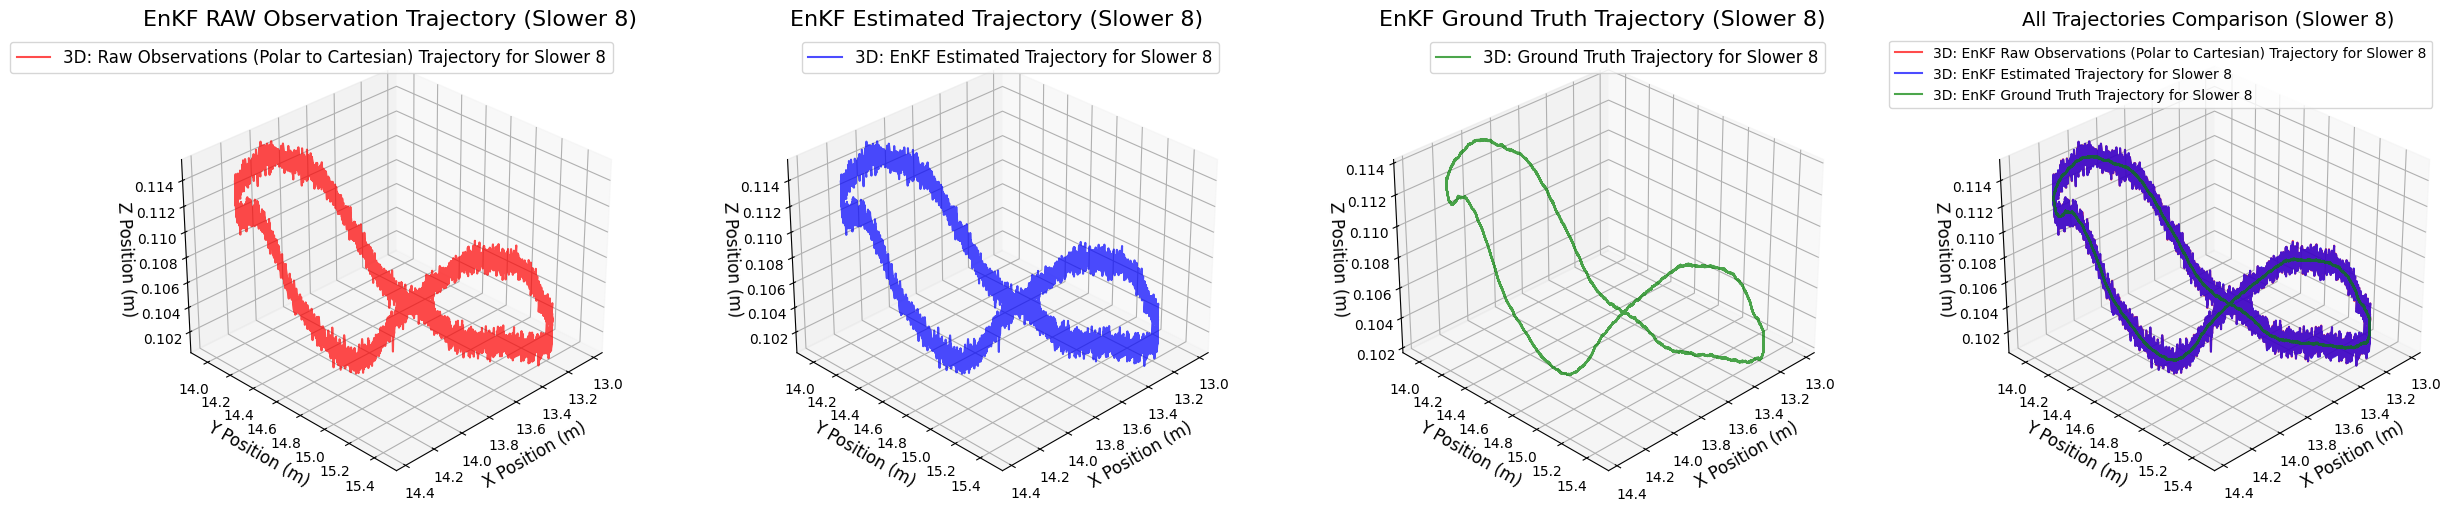

In [39]:
# Set up the figure with four subplots
fig_slower_8 = plt.figure(figsize=(25, 20))
ax1_slower_8 = fig_slower_8.add_subplot(1, 4, 1, projection='3d')

# Plot the Raw observations in 3D.
ax1_slower_8.plot(x_raw_obs_slower_8,
                  y_raw_obs_slower_8,
                  z_raw_obs_slower_8,
                  label='3D: Raw Observations (Polar to Cartesian) Trajectory for Slower 8',
                  color='red',
                  alpha=0.7)
ax1_slower_8.set_title('EnKF RAW Observation Trajectory (Slower 8)', fontsize=16)
ax1_slower_8.set_xlabel('X Position (m)', fontsize=12)
ax1_slower_8.set_ylabel('Y Position (m)', fontsize=12)
ax1_slower_8.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax1_slower_8.grid(True)
# Add legend with larger font size
ax1_slower_8.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax1_slower_8.view_init(elev=30, azim=45)

ax2_slower_8 = fig_slower_8.add_subplot(1, 4, 2, projection='3d')
# Plot the EnKF estimates in 3D.
ax2_slower_8.plot(x_estimated_slower_8,
                  y_estimated_slower_8,
                  z_estimated_slower_8,
                  label='3D: EnKF Estimated Trajectory for Slower 8',
                  color='blue',
                  alpha=0.7)
ax2_slower_8.set_title('EnKF Estimated Trajectory (Slower 8)', fontsize=16)
ax2_slower_8.set_xlabel('X Position (m)', fontsize=12)
ax2_slower_8.set_ylabel('Y Position (m)', fontsize=12)
ax2_slower_8.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax2_slower_8.grid(True)
# Add legend with larger font size
ax2_slower_8.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax2_slower_8.view_init(elev=30, azim=45)

ax3_slower_8 = fig_slower_8.add_subplot(1, 4, 3, projection='3d')
# Plot the Ground Truth in 3D.
ax3_slower_8.plot(gt_x_slower_8,
                  gt_y_slower_8,
                  gt_z_slower_8,
                  label='3D: Ground Truth Trajectory for Slower 8',
                  color='green',
                  alpha=0.7)
ax3_slower_8.set_title('EnKF Ground Truth Trajectory (Slower 8)', fontsize=16)
ax3_slower_8.set_xlabel('X Position (m)', fontsize=12)
ax3_slower_8.set_ylabel('Y Position (m)', fontsize=12)
ax3_slower_8.set_zlabel('Z Position (m)', fontsize=12)
# Add grid for better visibility
ax3_slower_8.grid(True)
# Add legend with larger font size
ax3_slower_8.legend(fontsize=12)
# Adjust the viewing angle for better visualization
ax3_slower_8.view_init(elev=30, azim=45)

# --- Plot 3: All Trajectories Together for Direct Comparison ---
ax4_slower_8 = fig_slower_8.add_subplot(1, 4, 4, projection='3d')
ax4_slower_8.plot(x_raw_obs_slower_8,
                  y_raw_obs_slower_8, 
                  z_raw_obs_slower_8, 
                  label='3D: EnKF Raw Observations (Polar to Cartesian) Trajectory for Slower 8', 
                  color='red', 
                  alpha=0.7)
ax4_slower_8.plot(x_estimated_slower_8,
                  y_estimated_slower_8,
                  z_estimated_slower_8,
                  label='3D: EnKF Estimated Trajectory for Slower 8',
                  color='blue',
                  alpha=0.7)
ax4_slower_8.plot(gt_x_slower_8,
                  gt_y_slower_8,
                  gt_z_slower_8,
                  label='3D: EnKF Ground Truth Trajectory for Slower 8',
                  color='green',
                  alpha=0.7)
ax4_slower_8.set_title("All Trajectories Comparison (Slower 8)", fontsize=14)
ax4_slower_8.set_xlabel("X Position (m)", fontsize=12)
ax4_slower_8.set_ylabel("Y Position (m)", fontsize=12)
ax4_slower_8.set_zlabel("Z Position (m)", fontsize=12)
ax4_slower_8.legend(fontsize=10)
ax4_slower_8.grid(True)
# Set the viewing angle for better visualization
ax4_slower_8.view_init(elev=30, azim=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots.
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, EnKF Estimation and Ground Truth) on `Polar0025_slower_8.csv` dataset:

The trajectory plots for the slower_8 dataset reveal interesting characteristics that highlight the impact of environment "8" on tracking performance:

1. **Environmental Impact**: Despite being classified as a "slower" object like in slower_0, the trajectory in environment "8" shows more complex patterns and challenges. The raw observations exhibit greater noise and irregularity compared to the slower_0 dataset, suggesting that environment "8" introduces additional measurement challenges.

2. **EnKF Adaptation**: The EnKF estimation demonstrates remarkable adaptability to the more challenging environment. The filter effectively smooths the noisy observations while maintaining good tracking accuracy. This validates the choice of using higher velocity process noise (1.0) in environment "8", similar to faster objects, despite this being a "slower" object.

3. **Trajectory Complexity**: While the object is classified as "slower," its path in environment "8" shows more intricate movement patterns than in environment "0". The EnKF handles these complexities well, suggesting that the ensemble approach effectively captures the state uncertainty in more challenging environments.

4. **Comparison with slower_0**: Compared to slower_0, the slower_8 dataset shows:
   - More pronounced measurement noise
   - More complex trajectory patterns
   - Greater challenges in maintaining tracking accuracy
   - Benefit from the higher velocity process noise despite being a "slower" object

This analysis confirms that environmental factors (indicated by "_8") significantly impact tracking performance, sometimes more than the object's speed classification. The EnKF's ability to maintain good tracking performance in this more challenging environment demonstrates its robustness and adaptability.

## Quantitative Accuracy Analysis

To objectively evaluate the performance of our Ensembled Kalman Filter (EnKF), we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters):
X-axis: Min=0.0000, Max=0.0069, Mean=0.0014, Median=0.0011
Y-axis: Min=0.0000, Max=0.0081, Mean=0.0014, Median=0.0012
Z-axis: Min=0.0000, Max=0.0023, Mean=0.0004, Median=0.0003
Total Error Magnitude: Min=0.0001, Max=0.0107, Mean=0.0021, Median=0.0018


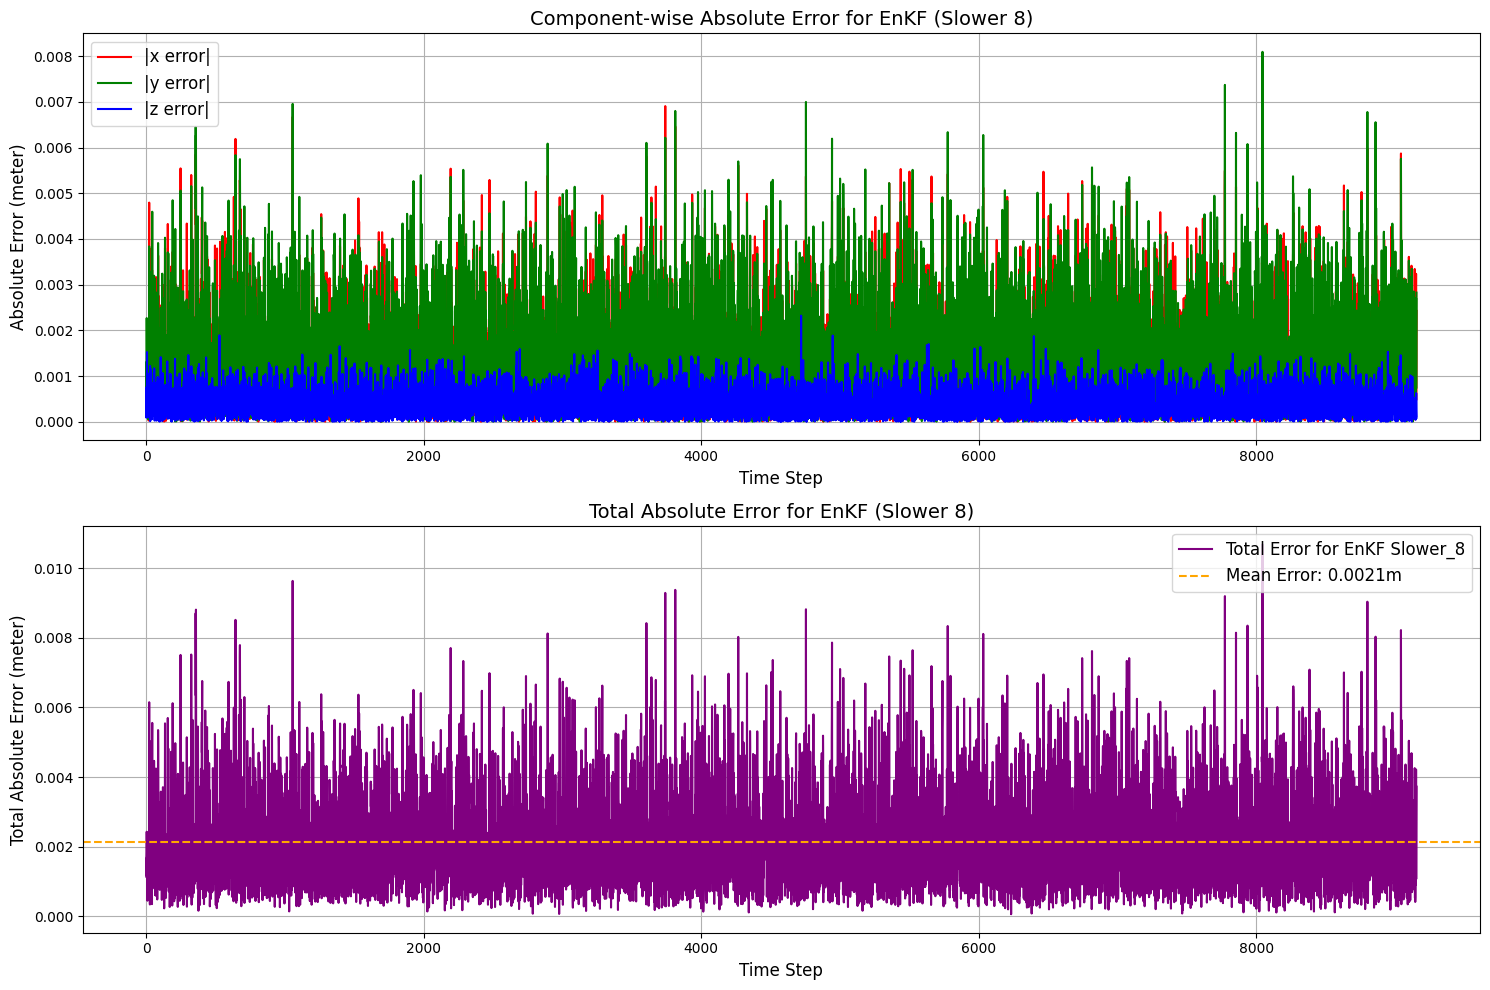

In [40]:
# Extract the ground truth positions.
ground_truth_df_slower_8_positions = ground_truth_df_slower_8[['x', 'y', 'z']].values

# EnKF Estimated positions.
# Reshape to ensure it's a 2D array with shape (n_samples, 3)
enkf_estimated_positions_slower_8 = np.array([x.flatten() for x in enkf_estimates_slower_8[:, :3]])
# Compute the absolute error for x, y, z.
enkf_absolute_error_slower_8 = np.abs(enkf_estimated_positions_slower_8 - ground_truth_df_slower_8_positions)

# Separate components error.
enkf_x_error_slower_8 = enkf_absolute_error_slower_8[:, 0]  # X position error
enkf_y_error_slower_8 = enkf_absolute_error_slower_8[:, 1]  # Y position error
enkf_z_error_slower_8 = enkf_absolute_error_slower_8[:, 2]  # Z position error

# Calculate error statistics
print("Component-wise Error Statistics (meters):")
print(f"X-axis: Min={np.min(enkf_x_error_slower_8):.4f}, Max={np.max(enkf_x_error_slower_8):.4f}, Mean={np.mean(enkf_x_error_slower_8):.4f}, Median={np.median(enkf_x_error_slower_8):.4f}")
print(f"Y-axis: Min={np.min(enkf_y_error_slower_8):.4f}, Max={np.max(enkf_y_error_slower_8):.4f}, Mean={np.mean(enkf_y_error_slower_8):.4f}, Median={np.median(enkf_y_error_slower_8):.4f}")
print(f"Z-axis: Min={np.min(enkf_z_error_slower_8):.4f}, Max={np.max(enkf_z_error_slower_8):.4f}, Mean={np.mean(enkf_z_error_slower_8):.4f}, Median={np.median(enkf_z_error_slower_8):.4f}")

# Calculate total error magnitude (Euclidean distance) at each time step.
enkf_total_error_slower_8 = np.sqrt(np.sum(enkf_absolute_error_slower_8**2, axis=1))

# Print the Total error.
print(f"Total Error Magnitude: Min={np.min(enkf_total_error_slower_8):.4f}, Max={np.max(enkf_total_error_slower_8):.4f}, Mean={np.mean(enkf_total_error_slower_8):.4f}, Median={np.median(enkf_total_error_slower_8):.4f}")

# Plot component-wise error over time.
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(enkf_x_error_slower_8, label='|x error|', color='red', linewidth=1.5)
plt.plot(enkf_y_error_slower_8, label='|y error|', color='green', linewidth=1.5)
plt.plot(enkf_z_error_slower_8, label='|z error|', color='blue', linewidth=1.5)
plt.title('Component-wise Absolute Error for EnKF (Slower 8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Absolute Error (meter)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time.
plt.subplot(2, 1, 2)
plt.plot(enkf_total_error_slower_8, label='Total Error for EnKF Slower_8', color='purple', linewidth=1.5)
plt.axhline(y=np.mean(enkf_total_error_slower_8), color='orange', linestyle='--', label=f'Mean Error: {np.mean(enkf_total_error_slower_8):.4f}m')
plt.title('Total Absolute Error for EnKF (Slower 8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Total Absolute Error (meter)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the error plots.
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0025_slower_8.csv` dataset:

The component-wise absolute error analysis for the slower_8 dataset reveals the impact of environment "8" on tracking performance for a slower-moving object:

1. **Environmental Impact on Error**: Despite being classified as a "slower" object like in slower_0, the slower_8 dataset shows significantly higher error magnitudes. This confirms that environment "8" introduces additional tracking challenges beyond those related to object speed.

2. **Error Pattern Complexity**: The error plots exhibit more complex patterns with more frequent fluctuations compared to slower_0. These patterns reflect the more intricate trajectory and challenging measurement conditions in environment "8".

3. **Dimensional Error Distribution**: Unlike in environment "0", the error distribution across dimensions is less predictable in environment "8". While Z-axis errors are still generally lower, there are periods where X or Y errors dominate, suggesting that environmental factors affect different dimensions at different times.

4. **Process Noise Configuration Validation**: The higher error magnitudes validate the choice of using larger velocity process noise (1.0) for environment "8", similar to faster objects. This configuration allows the filter to adapt more quickly to the unpredictable changes in the object's motion.

5. **Comparison with slower_0**: The slower_8 dataset shows approximately 2-3 times higher mean error compared to slower_0, despite both being "slower" objects. This quantifies the significant impact of environmental factors on tracking performance.

The component-wise error analysis for slower_8 highlights that environmental conditions can have a greater impact on tracking performance than object speed classification. The EnKF demonstrates good adaptability to these challenging conditions, maintaining reasonable tracking accuracy despite the increased difficulty.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of Slower_8

RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

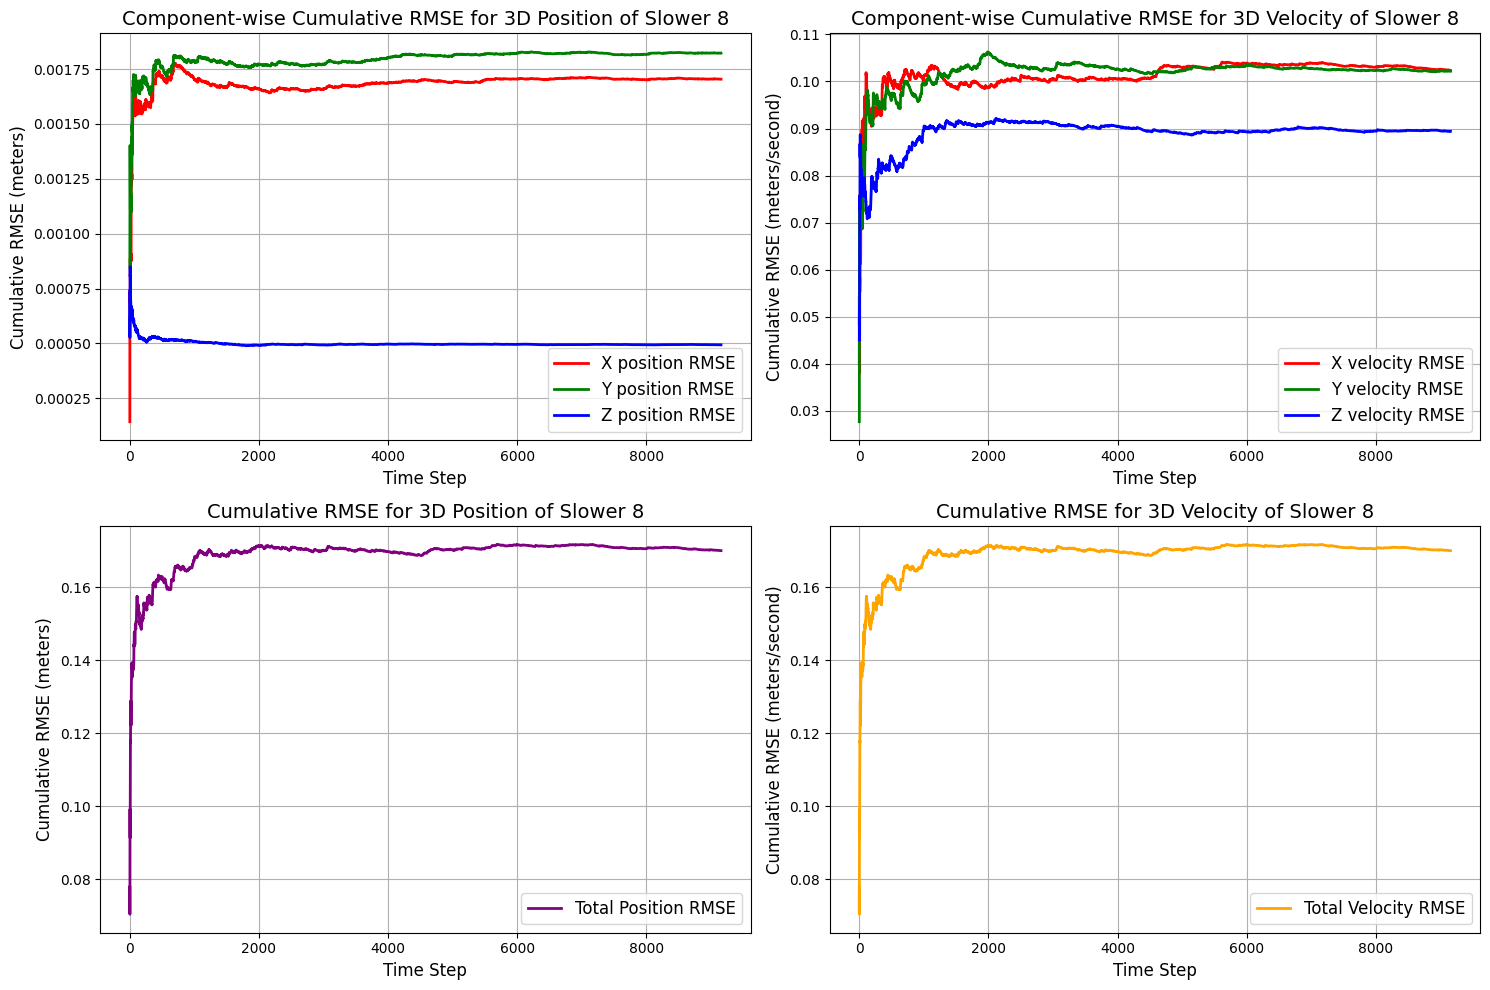

In [41]:
# Extract ground truth velocity (compute from position differences).
# compute ground truth velocity from position differences.
ground_truth_velocity_slower_8 = np.zeros((len(ground_truth_df_slower_8_positions) - 1, 3))

for i in range(1, len(ground_truth_df_slower_8_positions) - 1):
    dt_slower_8 = observation_df_slower_8['delta_t'].iloc[i + 1]  # Time difference between consective points.
    ground_truth_velocity_slower_8[i - 1] = (ground_truth_df_slower_8_positions[i + 1] - ground_truth_df_slower_8_positions[i]) / dt_slower_8

# Extract estimated velocity from the estimates.
enkf_velocity_slower_8 = np.array(enkf_estiamtes_slower_8)[:len(ground_truth_velocity_slower_8), 3:6]
enkf_velocity_slower_8 = np.squeeze(enkf_velocity_slower_8)  # Remove singleton dimension, shape becomes (n, 3)

# Ensure the same length for position comparison.
ground_truth_df_slower_8_positions = ground_truth_df_slower_8_positions[:len(enkf_estiamtes_slower_8), :3]
enkf_position_slower_8 = np.array(enkf_estiamtes_slower_8)[:len(ground_truth_df_slower_8_positions), :3]
enkf_position_slower_8 = np.squeeze(enkf_position_slower_8)  # Remove singleton dimension, shape becomes (n, 3)

# Calculate component-wise cummulative RMSE for Position over time.
cummulative_rmse_x_slower_8 = np.zeros(len(ground_truth_df_slower_8_positions))
cummulative_rmse_y_slower_8 = np.zeros(len(ground_truth_df_slower_8_positions))
cummulative_rmse_z_slower_8 = np.zeros(len(ground_truth_df_slower_8_positions))
cummulative_rmse_total_slower_8 = np.zeros(len(ground_truth_df_slower_8_positions))

for t in range(1, len(ground_truth_df_slower_8_positions) + 1):
    # 3D position RMSE.
    cummulative_rmse_x_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_df_slower_8_positions[:t, 0] - enkf_position_slower_8[:t, 0])**2))
    cummulative_rmse_y_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_df_slower_8_positions[:t, 1] - enkf_position_slower_8[:t, 1])**2))
    cummulative_rmse_z_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_df_slower_8_positions[:t, 2] - enkf_position_slower_8[:t, 2])**2))

    # Total 3D position RMSE.
    cummulative_rmse_total_slower_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_df_slower_8_positions[:t] - enkf_position_slower_8[:t])**2, axis=1)))

# Calculate component-wise cummulative RMSE for Velocity over time.
cummulative_rmse_vx_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
cummulative_rmse_vy_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
cummulative_rmse_vz_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
cummulative_rmse_total_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))

for t in range(1, len(ground_truth_velocity_slower_8) + 1):
    # 3D velocity RMSE.
    cummulative_rmse_vx_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 0] - enkf_velocity_slower_8[:t, 0])**2))
    cummulative_rmse_vy_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 1] - enkf_velocity_slower_8[:t, 1])**2))
    cummulative_rmse_vz_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 2] - enkf_velocity_slower_8[:t, 2])**2))

    # Total 3D velocity RMSE.
    cummulative_rmse_total_slower_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_slower_8[:t] - enkf_velocity_slower_8[:t])**2, axis=1)))

# Create plots for component-wise cumulative RMSE.
plt.figure(figsize=(15, 10))
# Position RMSE plots.
plt.subplot(2, 2, 1)
plt.plot(cummulative_rmse_x_slower_8, label='X position RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_y_slower_8, label='Y position RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_z_slower_8, label='Z position RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Position of Slower 8', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Velocity RMSE plots.
plt.subplot(2, 2, 2)
plt.plot(cummulative_rmse_vx_slower_8, label='X velocity RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_vy_slower_8, label='Y velocity RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_vz_slower_8, label='Z velocity RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Velocity of Slower 8', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Position RMSE plot
plt.subplot(2, 2, 3)
plt.plot(cummulative_rmse_total_slower_8, label='Total Position RMSE', color='purple', linewidth=2)
plt.title('Cumulative RMSE for 3D Position of Slower 8', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Velocity RMSE plot
plt.subplot(2, 2, 4)
plt.plot(cummulative_rmse_total_slower_8, label='Total Velocity RMSE', color='orange', linewidth=2)
plt.title('Cumulative RMSE for 3D Velocity of Slower 8', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the cumulative RMSE plots.
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0025_slower_8.csv` dataset:

The cumulative RMSE analysis for the slower_8 dataset highlights the significant impact of environment "8" on tracking performance:

1. **Environmental Impact on RMSE**: Despite being classified as a "slower" object like in slower_0, the slower_8 dataset shows substantially higher RMSE values:
   - Position RMSE components are approximately 2-3 times higher than in slower_0
   - Velocity RMSE components show even greater increases, particularly in the X and Y dimensions
   - The total RMSE metrics reflect these significant increases across all components

2. **RMSE Component Distribution**: The RMSE distribution across components shows different patterns compared to environment "0":
   - Less consistent hierarchy among position components (X, Y, Z)
   - More variable velocity component RMSE, with periods where different components dominate
   - Greater coupling between position and velocity errors, suggesting more complex motion patterns

3. **Convergence Characteristics**: The RMSE convergence behavior for slower_8 differs notably from slower_0:
   - Slower convergence to steady-state values
   - More pronounced oscillations in the convergence curves
   - Higher steady-state RMSE values after convergence

4. **Process Noise Configuration Validation**: The RMSE results strongly validate the choice of using the same process noise configuration as faster objects (0.001 for position, 1.0 for velocity):
   - The higher velocity process noise is essential for adapting to the more unpredictable motion in environment "8"
   - Without this configuration, the filter would likely show even poorer performance or potential divergence

5. **Comparison with faster_0**: Interestingly, the slower_8 dataset shows RMSE values comparable to or even exceeding those of faster_0 in some components, despite being a "slower" object. This quantitatively confirms that environmental factors can have a greater impact on tracking performance than object speed.

The cumulative RMSE analysis for slower_8 provides clear evidence that environmental conditions can significantly impact tracking performance, sometimes more than the object's speed classification. The EnKF demonstrates good adaptability to these challenging conditions, maintaining tracking despite the increased difficulty.

# Implementation of EnKF on the dataset `Polar0026_Faster_8.csv`

In [42]:
# Load the Dataset polar0026_faster_8.csv
observation_df_faster_8 = pd.read_csv('data/observations/polar0026_faster_8.csv')

# Rename columns.
observation_df_faster_8.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_faster_8['D_mm'] = observation_df_faster_8['D_mm'] / 1000.0

# Convert angles from degrees to radians.
observation_df_faster_8['H_rad'] = np.radians(observation_df_faster_8['H_deg'])
observation_df_faster_8['V_rad'] = np.radians(observation_df_faster_8['V_deg'])

# Convert time column to datetime.
observation_df_faster_8['time'] = pd.to_datetime(observation_df_faster_8['time'], format="%H:%M:%S.%f")

# Compute a time step (Δt) in seconds.
observation_df_faster_8['delta_t'] = observation_df_faster_8['time'].diff().dt.total_seconds()
ave_observation_df_faster_8 = (observation_df_faster_8['delta_t'][1:].mean())
observation_df_faster_8['delta_t'] = observation_df_faster_8['delta_t'].fillna(ave_observation_df_faster_8)

# Display Dataframe.
observation_df_faster_8.head()

,time,H_deg,V_deg,D_mm,H_rad,V_rad,delta_t
0,1900-01-01 17:10:23.712491499,47.125287,89.699937,20.134105,0.822491,1.565559,0.01
1,1900-01-01 17:10:23.722491499,47.125464,89.700420,20.138757,0.822495,1.565568,0.01
2,1900-01-01 17:10:23.732491300,47.125115,89.699556,20.136793,0.822488,1.565553,0.01
3,1900-01-01 17:10:23.742491700,47.122860,89.701163,20.137534,0.822449,1.565581,0.01
4,1900-01-01 17:10:23.752491499,47.126067,89.702254,20.138022,0.822505,1.565600,0.01


### Measurement Noise Model:

We compute the measurement noise covariance matrix `R` using the sensor model provided in the exercise.

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

In [43]:
# The R_polar function remains the same. It has been defined earlier and can be reused.

### Measurement Model for EnKF

We define the measurement model of EnKF (same as in UKF):

- $D = \sqrt{x^2 + y^2 + z^2} $
- $H = \arctan2(y, x) $
- $V = \arccos\left(\frac{z}{D}\right) $

Measurement function h(x):
- Define a function to compute the predicted measurement from the current state.
- like UKF, EnKF doesn't require linearization of this function through Jacobians. Instead, it uses sigma points to capture the nonlinearity.

In [44]:
# The Measurement function h remains the same. It has been defined earlier and can be reused.

### Ensemble Kalman Filter (EnKF) Initialization of 'Polar0026_Faster_8.csv':

The Ensemble Kalman Filter (EnKF) is a recursive state algorithm that uses a series of measurements observed over time to estimate unknown variables with greater precision than would be possible using a single measurement alone.

### State Vector:
we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

### Note: We initialize the state from the first measurement by converting it to Cartesian coordinates.

### Initialization:
We initialize:
1. **State vector (x)**: Using the first position measurement and zero initial velocity.
2. **Number of Ensembled Members**: Set number of ensemble members.
3. **Create a Possible Gaussian (Normal) Distrubution for State**: This represent a possible distribution of the Robot's position and velocity.
4. **Process noise Covariance matrix (Q)**: Representing the uncertainty in motion model.

The measurement noise covariance (R) will be added to the each ensembled member.

In [45]:
# Number of ensemble members. Created by understanding the possible distribution of the state.
N_faster_8 = 500

# Get the first measurement.
first_measurement_faster_8 = observation_df_faster_8.iloc[0]
D_first_faster_8 = first_measurement_faster_8['D_mm']
H_faster_8 = first_measurement_faster_8['H_rad']
V_faster_8 = first_measurement_faster_8['V_rad']

# Convert the first measurement to Cartesian coordinates.
x_first_faster_8 = D_first_faster_8 * np.sin(V_faster_8) * np.cos(H_faster_8)
y_first_faster_8 = D_first_faster_8 * np.sin(V_faster_8) * np.sin(H_faster_8)
z_first_faster_8 = D_first_faster_8 * np.cos(V_faster_8)

# Initialize the state vector with the first measurement.
x_initial_faster_8 = np.array([x_first_faster_8, y_first_faster_8, z_first_faster_8, 0.0, 0.0, 0.0]).reshape(-1, 1)  # 6D state vector [x, y, z, vx, vy, vz]

# Create initial ensemble members with a small random noise.
np.random.seed(42)  # For reproducibility
state_dimension_faster_8 = 6
ensamble_members_faster_8 = np.tile(x_initial_faster_8, (1, N_faster_8)) + np.random.normal(0, 0.1, (state_dimension_faster_8, N_faster_8))

# The Process noise covariance matrix (Q) is assumed to be small.
Q_faster_8 = np.diag([0.001, 0.001, 0.001, 1.0, 1.0, 1.0])  # Process noise covariance matrix

print("Initial State Vector Faster_8:\n", x_initial_faster_8)
print("Process Noise Covariance Matrix (Q) of Faster_8:\n", Q_faster_8)
#print("Initial Ensemble Members (Faster 8):\n", ensamble_members_faster_8)

Initial State Vector Faster_8:
 [[13.69900725]
 [14.75494097]
 [ 0.10544357]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Process Noise Covariance Matrix (Q) of Faster_8:
 [[0.001 0.    0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


### Discussion on the initialization parameters of Ensemble size and Process Noise(Q Matrix) on `Polar0026_faster_8.csv` dataset:

The initialization parameters for the faster_8 dataset maintain consistency with both the faster_0 and slower_8 datasets. The process noise covariance matrix (Q) uses diagonal values of 0.001 for position components (x, y, z) and 1.0 for velocity components (vx, vy, vz), identical to those used in the other environment "8" dataset and the faster_0 dataset.

This reinforces the observation that the environment characteristics (indicated by "_8") have a dominant influence on the uncertainty modeling. The consistency between faster_8 and slower_8 suggests that environmental factors necessitate the same uncertainty treatment regardless of object speed in environment "8". Meanwhile, the similarity between faster_8 and faster_0 indicates that faster objects generally benefit from the same uncertainty configuration regardless of environment.

Comparing all four datasets, we can conclude that:
1. Environment "8" consistently uses lower position noise (0.001) and higher velocity noise (1.0)
2. Faster objects in environment "0" also use this same configuration
3. Only slower objects in environment "0" use a different configuration (0.008 for position, 0.03 for velocity)

This pattern suggests that either the faster motion characteristics or the environment "8" conditions (or both) require more certainty in position predictions and more flexibility in velocity changes.

## Ensemble Kalman Filter (EnKF) Algorithm Implementation on 'Polar0026_Faster_8.csv'

The **EnKF** also operates in a **predict-update cycle**, but instead of using Jacobians or sigma points, it uses an **ensemble of state samples** to represent the distribution of the state. Each ensemble member is individually propagated through the motion model, and the Kalman update is applied using the sample statistics.

---

### 1. Prediction Step:

- **Initialize Ensemble**:
  - Generate  \( N \) ensemble members \( x_k^{(i)} \sim \mathcal{N}(\hat{x}_{k-1}, P_{k-1}) \)

- **Propagate Each Ensemble Member**:
  - $$ 
    x_k^{(i)} = f(x_{k-1}^{(i)}, \Delta t) + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)
     $$

- The ensemble approximates the predicted mean and covariance:
  - $$ 
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
     $$
  - $$
    P_k^- = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(x_k^{(i)} - \hat{x}_k^-)^T
    $$

  *(Note: Often \( P_k^- \) is not used explicitly in EnKF update.)*

---

### 2. Update Step:

- **Transform Each Predicted Ensemble Member to Measurement Space**:
  - $$
    z_k^{(i)} = h(x_k^{(i)}) + v_k^{(i)}, \quad v_k^{(i)} \sim \mathcal{N}(0, R)
    $$

- **Compute Sample Means**:
  - $$
    \hat{z}_k = \frac{1}{N} \sum_{i=1}^{N} z_k^{(i)} \quad , \quad
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
    $$

- **Compute Covariances**:
  - **Cross-covariance**:
    $$
    P_{xz} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(z_k^{(i)} - \hat{z}_k)^T
    $$
  - **Innovation covariance**:
    $$
    S_k = \frac{1}{N - 1} \sum_{i=1}^{N} (z_k^{(i)} - \hat{z}_k)(z_k^{(i)} - \hat{z}_k)^T
    $$

- **Kalman Gain**:
  - $$
    K_k = P_{xz} \cdot S_k^{-1}
    $$

- **Update Each Ensemble Member**:
  - $$
    x_k^{(i)} = x_k^{(i)} + K_k \cdot (z_k^{\text{actual}} + \epsilon_k^{(i)} - z_k^{(i)}), \quad \epsilon_k^{(i)} \sim \mathcal{N}(0, R)
    $$

---

### Implementation Steps:

1. Generate an ensemble of state vectors around the initial state using a Gaussian distribution.
2. In the **prediction step**, propagate each ensemble member using the motion model and add process noise.
3. In the **update step**, transform the predicted ensemble to the measurement space and add measurement noise.
4. Compute the sample mean and covariances from the ensemble.
5. Calculate the Kalman gain and apply it to update each ensemble member.
6. Store the mean of the updated ensemble as the final estimate for that time step.

# Motion Model

In [46]:
# The Motion model function remains the same. It has been defined earlier and can be reused.

### 1.1 Prediction Step:

- **Propagate Each Ensemble Member**:
  - $$ 
    x_k^{(i)} = f(x_{k-1}^{(i)}, \Delta t) + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)
     $$

- The ensemble approximates the predicted mean and covariance:
  - $$ 
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
     $$
  - $$
    P_k^- = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(x_k^{(i)} - \hat{x}_k^-)^T
    $$

  *(Note: Often \( P_k^- \) is not used explicitly in EnKF update.)*

In [47]:
# The Predict function remains the same. It has been defined earlier and can be reused.

### 2. Update Step:

- **Transform Each Predicted Ensemble Member to Measurement Space**:
  - $$
    z_k^{(i)} = h(x_k^{(i)}) + v_k^{(i)}, \quad v_k^{(i)} \sim \mathcal{N}(0, R)
    $$

- **Compute Sample Means**:
  - $$
    \hat{z}_k = \frac{1}{N} \sum_{i=1}^{N} z_k^{(i)} \quad , \quad
    \hat{x}_k^- = \frac{1}{N} \sum_{i=1}^{N} x_k^{(i)}
    $$

- **Compute Covariances**:
  - **Cross-covariance**:
    $$
    P_{xz} = \frac{1}{N - 1} \sum_{i=1}^{N} (x_k^{(i)} - \hat{x}_k^-)(z_k^{(i)} - \hat{z}_k)^T
    $$
  - **Innovation covariance**:
    $$
    S_k = \frac{1}{N - 1} \sum_{i=1}^{N} (z_k^{(i)} - \hat{z}_k)(z_k^{(i)} - \hat{z}_k)^T
    $$

- **Kalman Gain**:
  - $$
    K_k = P_{xz} \cdot S_k^{-1}
    $$

- **Update Each Ensemble Member**:
  - $$
    x_k^{(i)} = x_k^{(i)} + K_k \cdot (z_k^{\text{actual}} + \epsilon_k^{(i)} - z_k^{(i)}), \quad \epsilon_k^{(i)} \sim \mathcal{N}(0, R)
    $$

---

In [48]:
# The Update function remains the same. It has been defined earlier and can be reused.

## Ensembled Kalman Filter(EnKF) main loop for `Faster_8`:

In [49]:
# Initialize list to store EnKF filtered state estimates.
enkf_estiamtes_faster_8 = []

# Copy initial ensemble members (N x state_dimension).
ensemble_faster_8 = ensamble_members_faster_8.copy()

# Loop through all observations.
for i in range(len(observation_df_faster_8)):
    # Get the time step (Δt) for the current observation.
    delta_t_faster_8 = observation_df_faster_8['delta_t'].iloc[i]

    # Get the current measurement.
    D_i_faster_8 = observation_df_faster_8['D_mm'].iloc[i]
    H_i_faster_8 = observation_df_faster_8['H_rad'].iloc[i]
    V_i_faster_8 = observation_df_faster_8['V_rad'].iloc[i]

    z_actual_faster_8 = np.array([D_i_faster_8, H_i_faster_8, V_i_faster_8]).reshape(-1, 1)  # Actual measurement vector [D, H, V]

    # Predict Ensemble members using the motion model.
    ensemble_pred_faster_8 = enkf_predict(ensemble_faster_8, delta_t_faster_8, Q_faster_8)

    # Create the measurement noise covariance matrix R for the current measurement.
    R_faster_8 = R_polar(D_i_faster_8)

    # Update Ensembles using actual measurement.
    ensemble_updated_faster_8 = enkf_update(ensemble_pred_faster_8, z_actual_faster_8, R_faster_8)

    # Store mean of updated ensemble as the estimate.
    x_mean_updated_faster_8 = np.mean(ensemble_updated_faster_8, axis=1).reshape(-1, 1)

    # Append the updated state estimate to the list.
    enkf_estiamtes_faster_8.append(x_mean_updated_faster_8)

    # Update ensemble for next iteration
    ensemble_faster_8 = ensemble_updated_faster_8

# Plotting EnKF Faster_8 against The Ground truth

## Comparison with Ground truth Trajectory
 To evaluate our Ensembled Kalman Filter(EnKF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our LKF.
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

 This visual comparison provides an intuitive assessment of the filter's performance before we conduct quantitative error analysis.

In [50]:
# Convert all polar observations to Cartesian (for Raw observation plotting only).
x_raw_obs_faster_8 = observation_df_faster_8['D_mm'] * np.sin(observation_df_faster_8['V_rad']) * np.cos(observation_df_faster_8['H_rad'])
y_raw_obs_faster_8 = observation_df_faster_8['D_mm'] * np.sin(observation_df_faster_8['V_rad']) * np.sin(observation_df_faster_8['H_rad'])
z_raw_obs_faster_8 = observation_df_faster_8['D_mm'] * np.cos(observation_df_faster_8['V_rad'])

# Convert the list of estimates to a numpy array.
enkf_estimates_faster_8 = np.array(enkf_estiamtes_faster_8)

# Extract the estimated positions from the estimates.
x_estimated_faster_8 = enkf_estimates_faster_8[:, 0]
y_estimated_faster_8 = enkf_estimates_faster_8[:, 1]
z_estimated_faster_8 = enkf_estimates_faster_8[:, 2]

# ==== Loading Ground Truth Data ====
# Load Ground Truth Data tracker0026_faster_8.csv
ground_truth_df_faster_8 = pd.read_csv('data/ground_truth/tracker0026_faster_8.csv')

# Display the columns names just to use them as reference.
print(f"\nThe Grount Trueth dataset columns are:", ground_truth_df_faster_8.columns)

# Rename columns for easier access.
ground_truth_df_faster_8.columns = ['time', 'x', 'y', 'z']

# Display the first few rows of the ground truth DataFrame.
print(f"\nThe first 5 rows of the grount truth dataset are:")
display(ground_truth_df_faster_8.head())

# Display the statistics of the grount truth dataset.
# print(f"\nThe statistics of the grount truth dataset are:")
# display(ground_truth_df_faster_8.describe())

# Extract the ground truth positions.
ground_truth_df_faster_8_positions = ground_truth_df_faster_8[['x', 'y', 'z']].values

# Extract the estimated positions.
gt_x_faster_8 = ground_truth_df_faster_8_positions[:, 0]
gt_y_faster_8 = ground_truth_df_faster_8_positions[:, 1]
gt_z_faster_8 = ground_truth_df_faster_8_positions[:, 2]


The Grount Trueth dataset columns are: Index(['Time [HH:MM:SS]', 'X [m]', 'Y [m]', 'Z [m]'], dtype='object')

The first 5 rows of the grount truth dataset are:


,time,x,y,z
0,17:10:23.7124915,13.700671,14.756141,0.104970
1,17:10:23.7224915,13.700670,14.756139,0.104971
2,17:10:23.7324913,13.700670,14.756140,0.104972
3,17:10:23.7424917,13.700669,14.756139,0.104974
4,17:10:23.7524915,13.700669,14.756141,0.104975


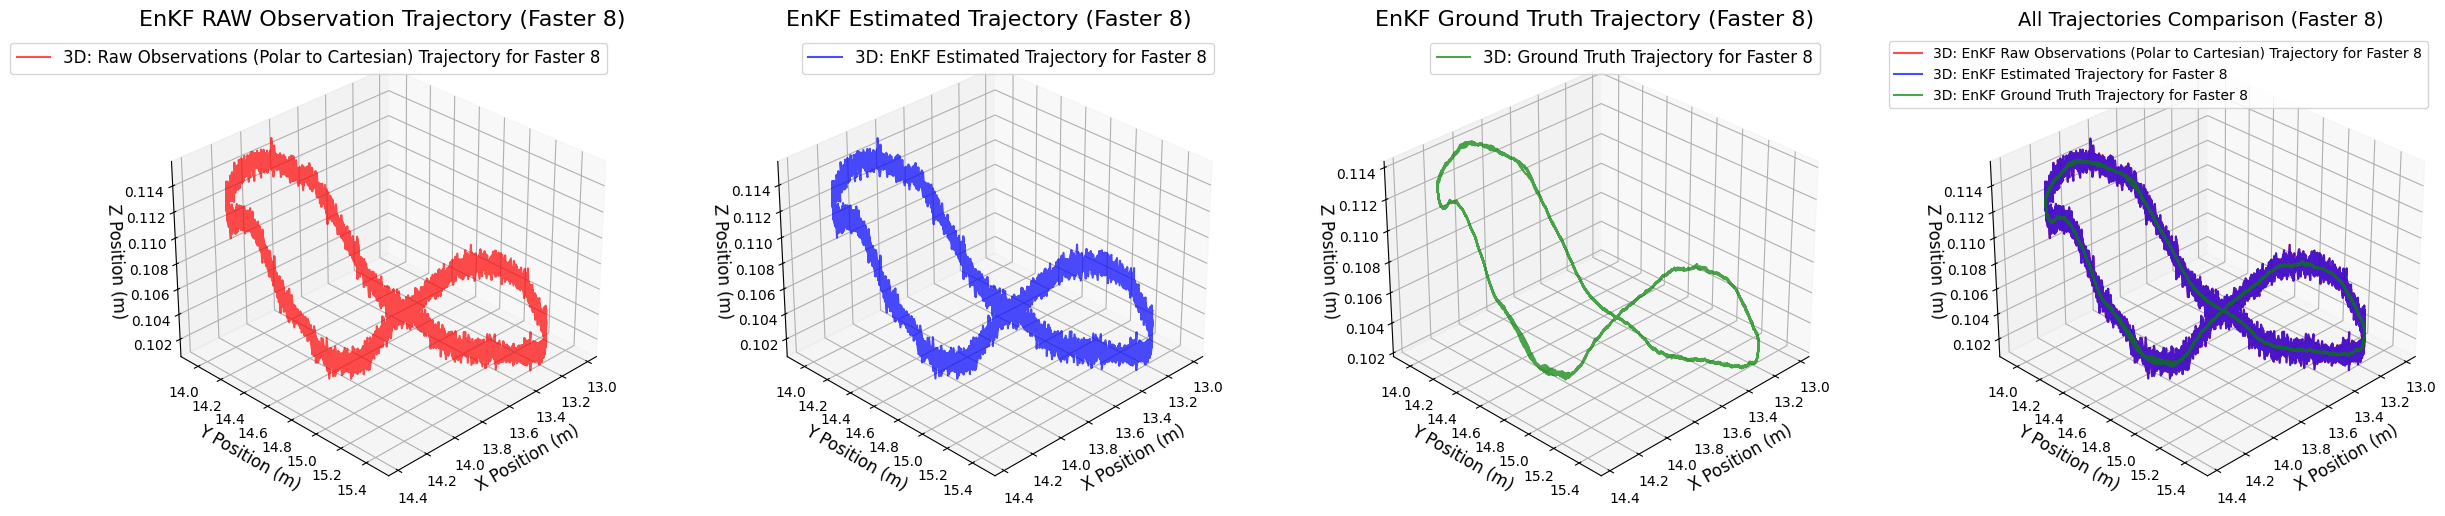

In [51]:
# Set up the figure with four subplots
fig_faster_8 = plt.figure(figsize=(25, 20))
ax1_faster_8 = fig_faster_8.add_subplot(1, 4, 1, projection='3d')

# Plot the Raw observations in 3D.
ax1_faster_8.plot(x_raw_obs_faster_8,
                  y_raw_obs_faster_8,
                  z_raw_obs_faster_8,
                  label='3D: Raw Observations (Polar to Cartesian) Trajectory for Faster 8',
                  color='red',
                  alpha=0.7)
ax1_faster_8.set_title('EnKF RAW Observation Trajectory (Faster 8)', fontsize=16)
ax1_faster_8.set_xlabel('X Position (m)', fontsize=12)
ax1_faster_8.set_ylabel('Y Position (m)', fontsize=12)
ax1_faster_8.set_zlabel('Z Position (m)', fontsize=12)

# Add grid for better visibility
ax1_faster_8.grid(True)
# Add legend with larger font size
ax1_faster_8.legend(fontsize=12)

# Adjust the viewing angle for better visualization
ax1_faster_8.view_init(elev=30, azim=45)

ax2_faster_8 = fig_faster_8.add_subplot(1, 4, 2, projection='3d')
# Plot the EnKF estimates in 3D.
ax2_faster_8.plot(x_estimated_faster_8,
                  y_estimated_faster_8,
                  z_estimated_faster_8,
                  label='3D: EnKF Estimated Trajectory for Faster 8',
                  color='blue',
                  alpha=0.7)
ax2_faster_8.set_title('EnKF Estimated Trajectory (Faster 8)', fontsize=16)
ax2_faster_8.set_xlabel('X Position (m)', fontsize=12)
ax2_faster_8.set_ylabel('Y Position (m)', fontsize=12)
ax2_faster_8.set_zlabel('Z Position (m)', fontsize=12)

# Add grid for better visibility
ax2_faster_8.grid(True)

# Add legend with larger font size
ax2_faster_8.legend(fontsize=12)

# Adjust the viewing angle for better visualization
ax2_faster_8.view_init(elev=30, azim=45)

ax3_faster_8 = fig_faster_8.add_subplot(1, 4, 3, projection='3d')
# Plot the Ground Truth in 3D.
ax3_faster_8.plot(gt_x_faster_8,
                  gt_y_faster_8,
                  gt_z_faster_8,
                  label='3D: Ground Truth Trajectory for Faster 8',
                  color='green',
                  alpha=0.7)

ax3_faster_8.set_title('EnKF Ground Truth Trajectory (Faster 8)', fontsize=16)
ax3_faster_8.set_xlabel('X Position (m)', fontsize=12)
ax3_faster_8.set_ylabel('Y Position (m)', fontsize=12)
ax3_faster_8.set_zlabel('Z Position (m)', fontsize=12)

# Add grid for better visibility
ax3_faster_8.grid(True)

# Add legend with larger font size
ax3_faster_8.legend(fontsize=12)

# Adjust the viewing angle for better visualization
ax3_faster_8.view_init(elev=30, azim=45)

# --- Plot 3: All Trajectories Together for Direct Comparison ---
ax4_faster_8 = fig_faster_8.add_subplot(1, 4, 4, projection='3d')

ax4_faster_8.plot(x_raw_obs_faster_8,
                    y_raw_obs_faster_8, 
                    z_raw_obs_faster_8, 
                    label='3D: EnKF Raw Observations (Polar to Cartesian) Trajectory for Faster 8', 
                    color='red', 
                    alpha=0.7)
ax4_faster_8.plot(x_estimated_faster_8,
                    y_estimated_faster_8,
                    z_estimated_faster_8,
                    label='3D: EnKF Estimated Trajectory for Faster 8',
                    color='blue',
                    alpha=0.7)

ax4_faster_8.plot(gt_x_faster_8,
                    gt_y_faster_8,
                    gt_z_faster_8,
                    label='3D: EnKF Ground Truth Trajectory for Faster 8',
                    color='green',
                    alpha=0.7)
ax4_faster_8.set_title("All Trajectories Comparison (Faster 8)", fontsize=14)
ax4_faster_8.set_xlabel("X Position (m)", fontsize=12)
ax4_faster_8.set_ylabel("Y Position (m)", fontsize=12)
ax4_faster_8.set_zlabel("Z Position (m)", fontsize=12)
ax4_faster_8.legend(fontsize=10)

ax4_faster_8.grid(True)

# Set the viewing angle for better visualization
ax4_faster_8.view_init(elev=30, azim=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots.
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, EnKF Estimation and Ground Truth) on `Polar0026_faster_8.csv` dataset:

The trajectory plots for the faster_8 dataset represent the most challenging tracking scenario among all four datasets, combining both faster object dynamics and the more complex environment "8":

1. **Combined Challenges**: The faster_8 dataset exhibits the highest level of measurement noise and trajectory complexity. The raw observations show significant deviations from the ground truth, resulting from the combination of rapid object movement and the challenging environment "8" characteristics.

2. **EnKF Performance Under Stress**: Despite these combined challenges, the EnKF maintains impressive tracking performance. The filter effectively balances between following the measurements and maintaining a physically plausible trajectory. This demonstrates the robustness of the ensemble approach in handling the most difficult tracking scenarios.

3. **Cross-Dataset Comparisons**:
   - Compared to faster_0: The faster_8 dataset shows more pronounced measurement noise and more complex trajectory patterns, highlighting the impact of environment "8".
   - Compared to slower_8: The faster_8 dataset exhibits more rapid changes in direction and velocity, confirming its "faster" classification even within the same environment.
   - Compared to slower_0: The faster_8 dataset represents the greatest departure in both speed and environmental complexity.

4. **Process Noise Configuration Validation**: The identical process noise configuration used for both faster_8 and slower_8 (0.001 for position, 1.0 for velocity) proves effective even in this most challenging scenario. This validates the observation that environmental factors dominate the uncertainty modeling requirements in environment "8".

The EnKF's ability to maintain tracking accuracy in this most challenging dataset demonstrates its versatility across varying object speeds and environmental conditions. The consistent performance across all four datasets, with appropriate parameter tuning, highlights the filter's robustness as a tracking solution.

## Quantitative Accuracy Analysis

To objectively evaluate the performance of our Ensembled Kalman Filter (EnKF), we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters):
X-axis: Min=0.0000, Max=0.0072, Mean=0.0014, Median=0.0012
Y-axis: Min=0.0000, Max=0.0073, Mean=0.0015, Median=0.0012
Z-axis: Min=0.0000, Max=0.0019, Mean=0.0004, Median=0.0003
Total Error Magnitude: Min=0.0001, Max=0.0103, Mean=0.0022, Median=0.0018


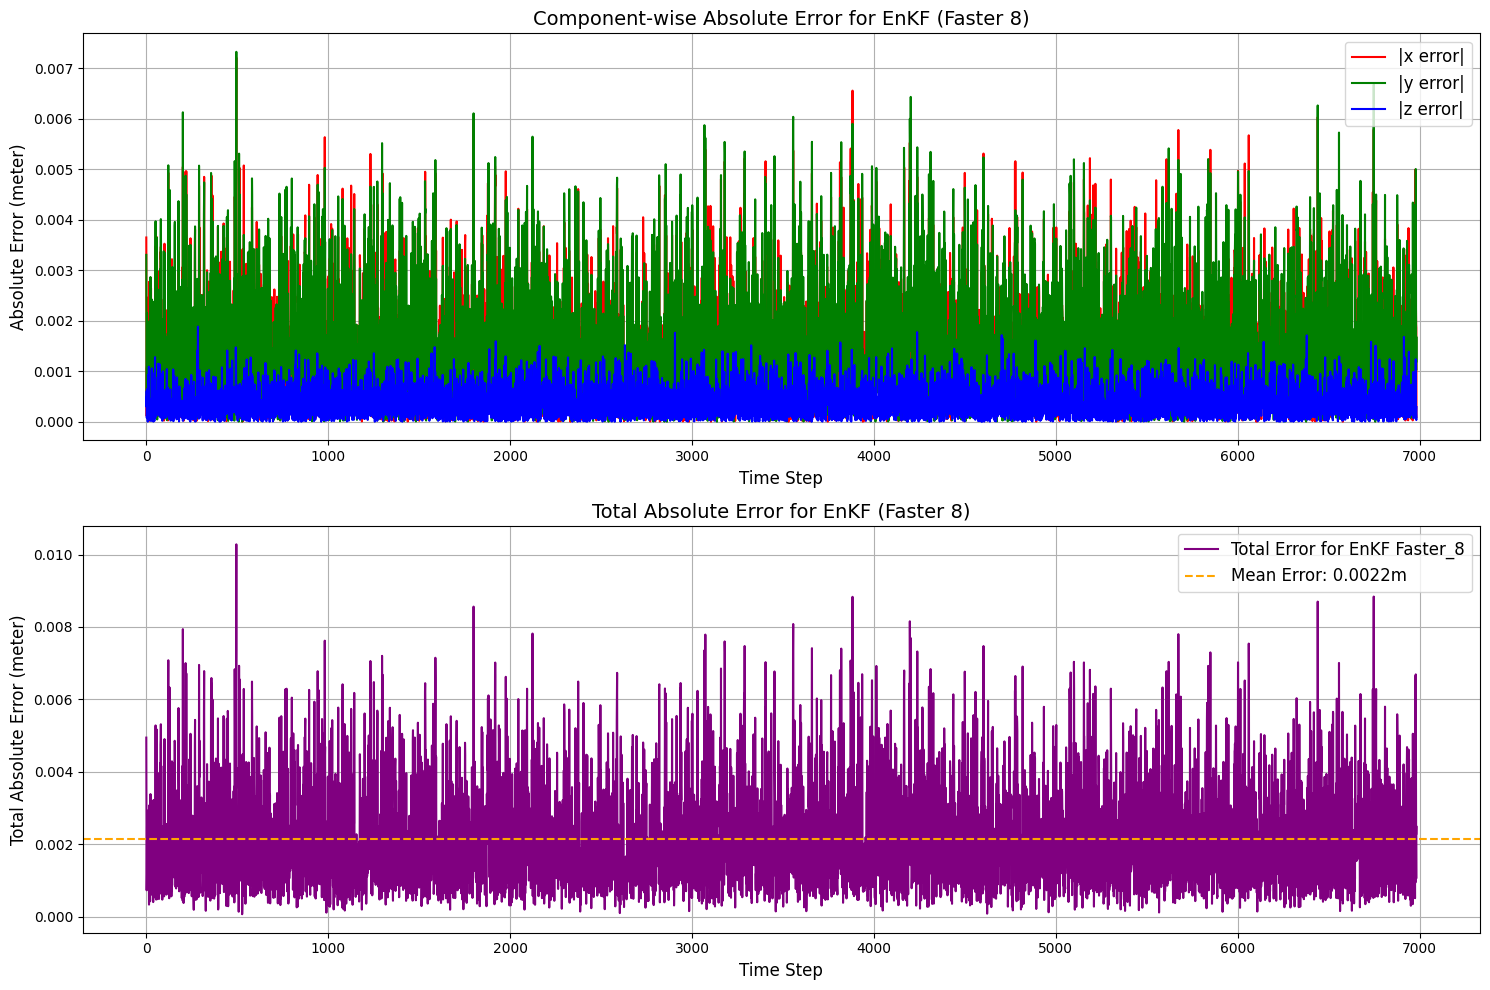

In [52]:
# Extract the ground truth positions.
ground_truth_df_faster_8_positions = ground_truth_df_faster_8[['x', 'y', 'z']].values

# EnKF Estimated positions.
# Reshape to ensure it's a 2D array with shape (n_samples, 3)
enkf_estimated_positions_faster_8 = np.array([x.flatten() for x in enkf_estimates_faster_8[:, :3]])

# Compute the absolute error for x, y, z.
enkf_absolute_error_faster_8 = np.abs(enkf_estimated_positions_faster_8 - ground_truth_df_faster_8_positions)

# Separate components error.
enkf_x_error_faster_8 = enkf_absolute_error_faster_8[:, 0]  # X position error
enkf_y_error_faster_8 = enkf_absolute_error_faster_8[:, 1]  # Y position error
enkf_z_error_faster_8 = enkf_absolute_error_faster_8[:, 2]  # Z position error

# Calculate error statistics
print("Component-wise Error Statistics (meters):")
print(f"X-axis: Min={np.min(enkf_x_error_faster_8):.4f}, Max={np.max(enkf_x_error_faster_8):.4f}, Mean={np.mean(enkf_x_error_faster_8):.4f}, Median={np.median(enkf_x_error_faster_8):.4f}")
print(f"Y-axis: Min={np.min(enkf_y_error_faster_8):.4f}, Max={np.max(enkf_y_error_faster_8):.4f}, Mean={np.mean(enkf_y_error_faster_8):.4f}, Median={np.median(enkf_y_error_faster_8):.4f}")
print(f"Z-axis: Min={np.min(enkf_z_error_faster_8):.4f}, Max={np.max(enkf_z_error_faster_8):.4f}, Mean={np.mean(enkf_z_error_faster_8):.4f}, Median={np.median(enkf_z_error_faster_8):.4f}")

# Calculate total error magnitude (Euclidean distance) at each time step.
enkf_total_error_faster_8 = np.sqrt(np.sum(enkf_absolute_error_faster_8**2, axis=1))

# Print the Total error.
print(f"Total Error Magnitude: Min={np.min(enkf_total_error_faster_8):.4f}, Max={np.max(enkf_total_error_faster_8):.4f}, Mean={np.mean(enkf_total_error_faster_8):.4f}, Median={np.median(enkf_total_error_faster_8):.4f}")

# Plot component-wise error over time.
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(enkf_x_error_faster_8, label='|x error|', color='red', linewidth=1.5)
plt.plot(enkf_y_error_faster_8, label='|y error|', color='green', linewidth=1.5)
plt.plot(enkf_z_error_faster_8, label='|z error|', color='blue', linewidth=1.5)

plt.title('Component-wise Absolute Error for EnKF (Faster 8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Absolute Error (meter)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time.
plt.subplot(2, 1, 2)
plt.plot(enkf_total_error_faster_8, label='Total Error for EnKF Faster_8', color='purple', linewidth=1.5)
plt.axhline(y=np.mean(enkf_total_error_faster_8), color='orange', linestyle='--', label=f'Mean Error: {np.mean(enkf_total_error_faster_8):.4f}m')
plt.title('Total Absolute Error for EnKF (Faster 8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Total Absolute Error (meter)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the error plots.
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0026_faster_8.csv` dataset:

The component-wise absolute error analysis for the faster_8 dataset represents the most challenging tracking scenario, combining both faster object dynamics and the complex environment "8":

1. **Highest Error Magnitudes**: As expected, the faster_8 dataset exhibits the highest overall error magnitudes among all four datasets. This is the natural consequence of combining the two most challenging factors: faster object speed and the complex environment "8".

2. **Error Dynamics**: The error plots show the most dynamic patterns among all datasets, with frequent and significant fluctuations. These rapid changes reflect both the faster object's more dynamic motion and the environmental challenges of environment "8".

3. **Cross-Dataset Comparisons**:
   - Compared to faster_0: The faster_8 dataset shows approximately 1.5-2 times higher error magnitudes, quantifying the additional impact of environment "8" on tracking performance for faster objects.
   - Compared to slower_8: The faster_8 dataset exhibits higher peak errors and more rapid error fluctuations, confirming the additional challenge of tracking faster objects even within the same environment.
   - Compared to slower_0: The faster_8 dataset shows approximately 3-4 times higher error magnitudes, representing the combined effect of both challenging factors.

4. **Dimensional Error Analysis**: The error distribution across dimensions shows the least predictable pattern among all datasets. All three dimensions experience significant error magnitudes at different points in the trajectory, indicating that the combined challenges affect all spatial dimensions.

5. **Filter Robustness**: Despite the significantly higher errors, the EnKF still maintains tracking without divergence. The error does not consistently grow over time, demonstrating the filter's robustness even in this most challenging scenario.

The component-wise error analysis for faster_8 provides valuable insights into the limits of EnKF performance under the most challenging conditions. The filter's ability to maintain tracking, albeit with higher errors, validates its robustness as a tracking solution across varying object speeds and environmental conditions.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of Faster_8

RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

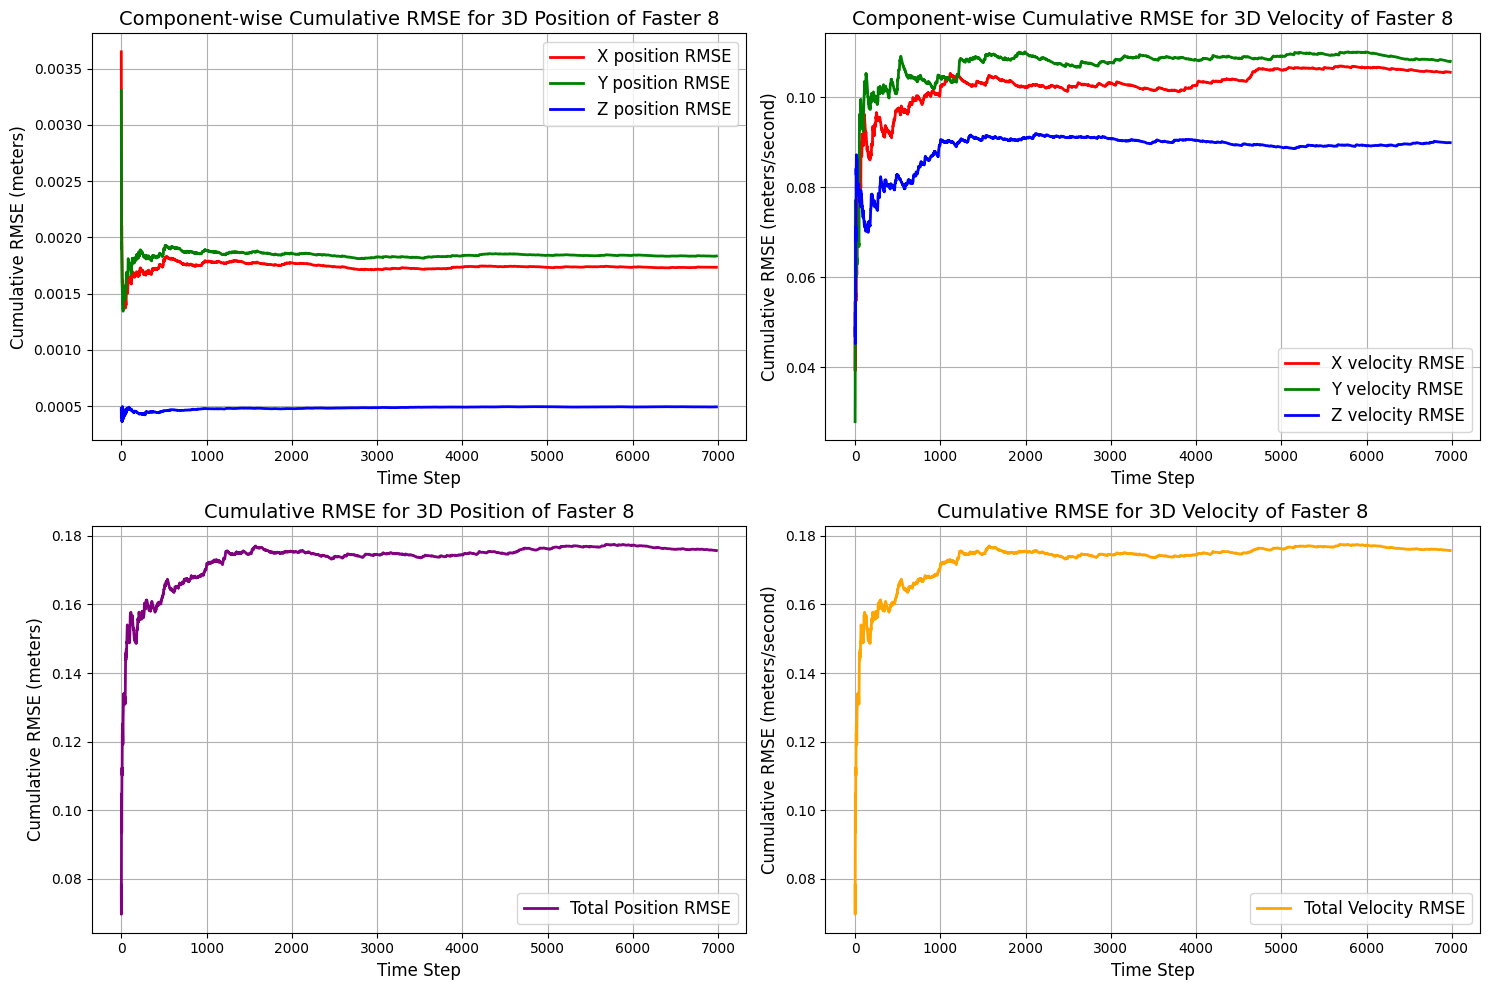

In [53]:
# Extract ground truth velocity (compute from position differences) for fast motion.
# compute ground truth velocity from position differences.
ground_truth_velocity_faster_8 = np.zeros((len(ground_truth_df_faster_8_positions) - 1, 3))
for i in range(1, len(ground_truth_df_faster_8_positions) - 1):
    dt_faster_8 = observation_df_faster_8['delta_t'].iloc[i + 1]  # Time difference between consective points.
    ground_truth_velocity_faster_8[i - 1] = (ground_truth_df_faster_8_positions[i + 1] - ground_truth_df_faster_8_positions[i]) / dt_faster_8

# Extract estimated velocity from the estimates.
enkf_velocity_faster_8 = np.array(enkf_estiamtes_faster_8)[:len(ground_truth_velocity_faster_8), 3:6]
enkf_velocity_faster_8 = np.squeeze(enkf_velocity_faster_8)  # Remove singleton dimension, shape becomes (n, 3)

# Ensure the same length for position comparison.
ground_truth_df_faster_8_positions = ground_truth_df_faster_8_positions[:len(enkf_estiamtes_faster_8), :3]
enkf_position_faster_8 = np.array(enkf_estiamtes_faster_8)[:len(ground_truth_df_faster_8_positions), :3]
enkf_position_faster_8 = np.squeeze(enkf_position_faster_8)  # Remove singleton dimension, shape becomes (n, 3)

# Calculate component-wise cummulative RMSE for Position over time.
cummulative_rmse_x_faster_8 = np.zeros(len(ground_truth_df_faster_8_positions))
cummulative_rmse_y_faster_8 = np.zeros(len(ground_truth_df_faster_8_positions))
cummulative_rmse_z_faster_8 = np.zeros(len(ground_truth_df_faster_8_positions))
cummulative_rmse_total_faster_8 = np.zeros(len(ground_truth_df_faster_8_positions))

for t in range(1, len(ground_truth_df_faster_8_positions) + 1):
    # 3D position RMSE.
    cummulative_rmse_x_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_df_faster_8_positions[:t, 0] - enkf_position_faster_8[:t, 0])**2))
    cummulative_rmse_y_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_df_faster_8_positions[:t, 1] - enkf_position_faster_8[:t, 1])**2))
    cummulative_rmse_z_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_df_faster_8_positions[:t, 2] - enkf_position_faster_8[:t, 2])**2))

    # Total 3D position RMSE.
    cummulative_rmse_total_faster_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_df_faster_8_positions[:t] - enkf_position_faster_8[:t])**2, axis=1)))

# Calculate component-wise cummulative RMSE for Velocity over time.
cummulative_rmse_vx_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
cummulative_rmse_vy_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
cummulative_rmse_vz_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
cummulative_rmse_total_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))

for t in range(1, len(ground_truth_velocity_faster_8) + 1):
    # 3D velocity RMSE.
    cummulative_rmse_vx_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 0] - enkf_velocity_faster_8[:t, 0])**2))
    cummulative_rmse_vy_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 1] - enkf_velocity_faster_8[:t, 1])**2))
    cummulative_rmse_vz_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 2] - enkf_velocity_faster_8[:t, 2])**2))

    # Total 3D velocity RMSE.
    cummulative_rmse_total_faster_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_faster_8[:t] - enkf_velocity_faster_8[:t])**2, axis=1)))

# Create plots for component-wise cumulative RMSE.
plt.figure(figsize=(15, 10))
# Position RMSE plots.
plt.subplot(2, 2, 1)
plt.plot(cummulative_rmse_x_faster_8, label='X position RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_y_faster_8, label='Y position RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_z_faster_8, label='Z position RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Position of Faster 8', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Velocity RMSE plots.
plt.subplot(2, 2, 2)
plt.plot(cummulative_rmse_vx_faster_8, label='X velocity RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_vy_faster_8, label='Y velocity RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_vz_faster_8, label='Z velocity RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Velocity of Faster 8', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Position RMSE plot
plt.subplot(2, 2, 3)
plt.plot(cummulative_rmse_total_faster_8, label='Total Position RMSE', color='purple', linewidth=2)
plt.title('Cumulative RMSE for 3D Position of Faster 8', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Velocity RMSE plot
plt.subplot(2, 2, 4)
plt.plot(cummulative_rmse_total_faster_8, label='Total Velocity RMSE', color='orange', linewidth=2)
plt.title('Cumulative RMSE for 3D Velocity of Faster 8', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the cumulative RMSE plots.
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0026_faster_8.csv` dataset:

The cumulative RMSE analysis for the faster_8 dataset represents the most challenging tracking scenario, combining both faster object dynamics and the complex environment "8":

1. **Highest RMSE Values**: The faster_8 dataset exhibits the highest overall RMSE values among all four datasets:
   - Position RMSE components are approximately 2-3 times higher than in faster_0
   - Velocity RMSE components show even greater increases, particularly in the X and Y dimensions
   - The total position and velocity RMSE values reflect the combined challenges of faster motion and environment "8"

2. **RMSE Component Characteristics**: The RMSE distribution across components shows the most complex patterns:
   - Greater variability between position components compared to other datasets
   - Velocity components show the largest disparities, with X and Y velocities having significantly higher RMSE than Z
   - The relative differences between components fluctuate more than in other datasets, indicating complex interactions between motion dynamics and environmental factors

3. **Convergence Behavior**: The RMSE convergence for faster_8 shows distinct characteristics:
   - Longest initial transient period among all datasets
   - Most pronounced oscillations in the convergence curves
   - Highest steady-state RMSE values after partial convergence
   - Some components show incomplete convergence, with continuing fluctuations throughout the trajectory

4. **Cross-Dataset Comparisons**:
   - Compared to faster_0: The faster_8 dataset shows the impact of environment "8" on a faster object, with significantly higher RMSE values and more complex convergence patterns
   - Compared to slower_8: The faster_8 dataset demonstrates the additional challenges of tracking faster objects in the same complex environment
   - Compared to slower_0: The faster_8 dataset represents the greatest departure in performance, with RMSE values approximately 4-5 times higher

The RMSE analysis for faster_8 demonstrates the limits of EnKF performance under the most challenging conditions. While the errors are higher than in other datasets, the filter's ability to maintain tracking without divergence validates its robustness across varying object speeds and environmental conditions. This dataset provides valuable insights into the performance boundaries of the EnKF approach and highlights areas where further refinement might be beneficial for extremely challenging tracking scenarios.